In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import itertools
from matplotlib import cm

import os
import seaborn as sns
from os import listdir
from os.path import isfile, join
import scipy.stats as stats

In [2]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)

In [3]:
filenm = 'jul15_master'
xlsxname = filenm+'.xlsx'
savefilesto = '/Volumes/SAF_Data/bar-manuscript_sum22/data-interp/'
mypath = f'/Volumes/SAF_Data/NAYS2DH_files/Data/BarCSVs/concat-files/{xlsxname}'
allbars = pd.read_excel(mypath, header=0, usecols = 'A:BF') ## change if you add more columns to the raw dataset


In [4]:
allbars['CVFlowDepth'] = allbars['SDFlowDepth']/allbars['MeanFlowDepth']
allbars['CVVelocity'] = allbars['SDVelocity']/allbars['MeanVelocity']
allbars['Skew Abs'] = abs(allbars['Angle Skewness'])


In [5]:
# df.loc[ df[“column_name”] == “some_value”, “column_name”] = “value”
allbars['TempAgg'] = allbars['MedClinoHt']/allbars['MaxClinoHt']
allbars['Skew Binned'] = allbars['Skew Abs']
allbars.loc[np.logical_or(allbars['Skew Abs'] > 1, allbars['Skew Abs'] < 3), 'Skew Binned'] = 1
allbars.loc[allbars['Skew Abs'] < 1, 'Skew Binned'] = 0
allbars.loc[allbars['Skew Abs'] > 3, 'Skew Binned'] = 2

allbars['Co Binned'] = allbars['Skew Abs']
allbars.loc[np.logical_or(allbars['CoherenceVal'] > 2, allbars['CoherenceVal'] <= 3), 'Co Binned'] = 1
allbars.loc[allbars['CoherenceVal'] <= 2, 'Co Binned'] = 0

allbars.loc[allbars['CoherenceVal'] > 3, 'Co Binned'] = 2

In [6]:
allbars['BSR Binned'] = allbars['Basal Surf Relief']
allbars.loc[np.logical_or(allbars['Basal Surf Relief'] > 0.5, allbars['Basal Surf Relief'] < 1), 'BSR Binned'] = 1
allbars.loc[allbars['Basal Surf Relief'] < 0.5, 'BSR Binned'] = 0
allbars.loc[allbars['Basal Surf Relief'] > 1, 'BSR Binned'] = 2

In [7]:
## recalc facies
d50 = 0.00031
# chezy_rough = 18*(np.log10(4*allbars['MedFlowDepth']/d50)) #i think this is log10, else they would've put ln no?

med_mmp =(1000*(allbars['MedVelocity']**2))/(1650*((18*(np.log10(4*allbars['MedFlowDepth']/d50)))**2)*d50)##### modified mobility parameter
allbars['MeanFacies'] =(1000*(allbars['MeanVelocity']**2))/(1650*((18*(np.log10(4*allbars['MeanFlowDepth']/d50)))**2)*d50)##### modified mobility parameter
allbars['MedFacies'] =(1000*(allbars['MedVelocity']**2))/(1650*((18*(np.log10(4*allbars['MedFlowDepth']/d50)))**2)*d50)##### modified mobility parameter

In [8]:
allbars['BinFacMean'] = allbars['MeanFacies']
allbars.loc[allbars['MeanFacies'] < 0.17, 'BinFacMean'] = 'LB'
allbars.loc[allbars['MeanFacies'] > 0.17, 'BinFacMean'] = 'UB'

In [9]:
allbars['BarHeight/MaxFD'] = allbars['BarHeight']/allbars['MaxFlowDepth']
allbars['MaxClino/MaxFD'] = allbars['MaxClinoHt']/allbars['MaxFlowDepth']
allbars['MaxClino/MedFD'] = allbars['MaxClinoHt']/allbars['MedFlowDepth']
allbars['MedClino/MedFD'] = allbars['MedClinoHt']/allbars['MedFlowDepth']

In [42]:
allbars['BFscaling'] = allbars['MaxClinoHt']/1.5

Text(0.5, 0, 'MMP, aka facies')

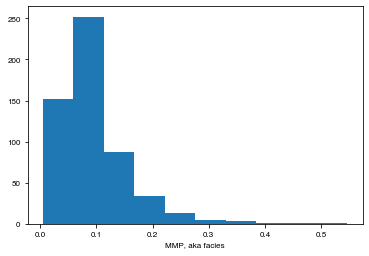

In [10]:
plt.hist(allbars['MeanFacies']);
plt.xlabel('MMP, aka facies')

In [11]:
##–––––––––––––––––––––––––––––– Summary for Preservation——————————————————————————————————##
pres_summary = pd.DataFrame(columns = ['PreservChar'])
variabs = ['BarHeight', 'BarWidth', 'BarAspect', 'ChannelProp', 'Angle Skewness', 
           'Basal Surf Relief', 'Median dzdx', 'MeanClinoICD', 'MeanFlowDepth', 'MeanVelocity', 'MeanShear', 'MeanFacies']
diag_char = ['FP', 'PP', 'TR']
for char in diag_char:
    tempdf = pd.DataFrame([char], columns = ['PreservChar'])
    
    for var in variabs:
        tempdf[[var+'mean', var+'median', var+'iqr']] = pd.DataFrame([[np.nanmean(allbars[var][allbars['PreservChar']==char]), 
                                                                             np.nanmedian(allbars[var][allbars['PreservChar']==char]), 
                                                                             stats.iqr(allbars[var][allbars['PreservChar']==char], nan_policy = 'omit')]])
    pres_summary = pd.concat([pres_summary, tempdf], ignore_index = True)
    
##–––––––––––––––––––––––––––––– Summary for Coherence——————————————————————————————————##
coh_summary = pd.DataFrame(columns = ['CoherenceVal'])
diag_char = [1, 2, 3, 4, 5]
for char in diag_char:
    tempdf = pd.DataFrame([char], columns = ['CoherenceVal'])
    
    for var in variabs:
        tempdf[[var+'mean', var+'median', var+'iqr']] = pd.DataFrame([[np.nanmean(allbars[var][allbars['CoherenceVal']==char]), 
                                                                             np.nanmedian(allbars[var][allbars['CoherenceVal']==char]), 
                                                                             stats.iqr(allbars[var][allbars['CoherenceVal']==char], nan_policy = 'omit')]])
    coh_summary = pd.concat([coh_summary, tempdf], ignore_index = True)

##–––––––––––––––––––––––––––––– Summary for Process ——————————————————————————————————##
proc_summary = pd.DataFrame(columns = ['process interp'])
diag_char = np.unique(allbars['process interp'])

for char in diag_char:
    tempdf = pd.DataFrame([char], columns = ['process interp'])
    
    for var in variabs:
        tempdf[[var+'mean', var+'median', var+'iqr']] = pd.DataFrame([[np.nanmean(allbars[var][allbars['process interp']==char]), 
                                                                             np.nanmedian(allbars[var][allbars['process interp']==char]), 
                                                                             stats.iqr(allbars[var][allbars['process interp']==char], nan_policy = 'omit')]])
    proc_summary = pd.concat([proc_summary, tempdf], ignore_index = True)
summary_table = pd.concat([pres_summary, coh_summary, proc_summary], ignore_index = True)
summary_table.to_csv(f'{savefilesto}{filenm}_summary.csv')

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Basal Surf Relief', ylabel='Median dzdx'>

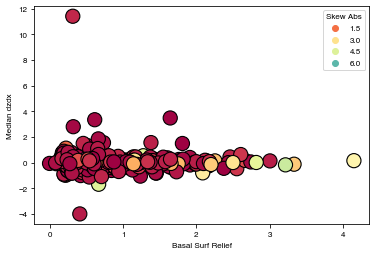

In [12]:
sns.scatterplot(allbars['Basal Surf Relief'], allbars['Median dzdx'], hue = allbars['Skew Abs'], s=200, ec = 'k', palette='Spectral', hue_norm=(allbars['Skew Abs'].min(), allbars['Skew Abs'].max()))

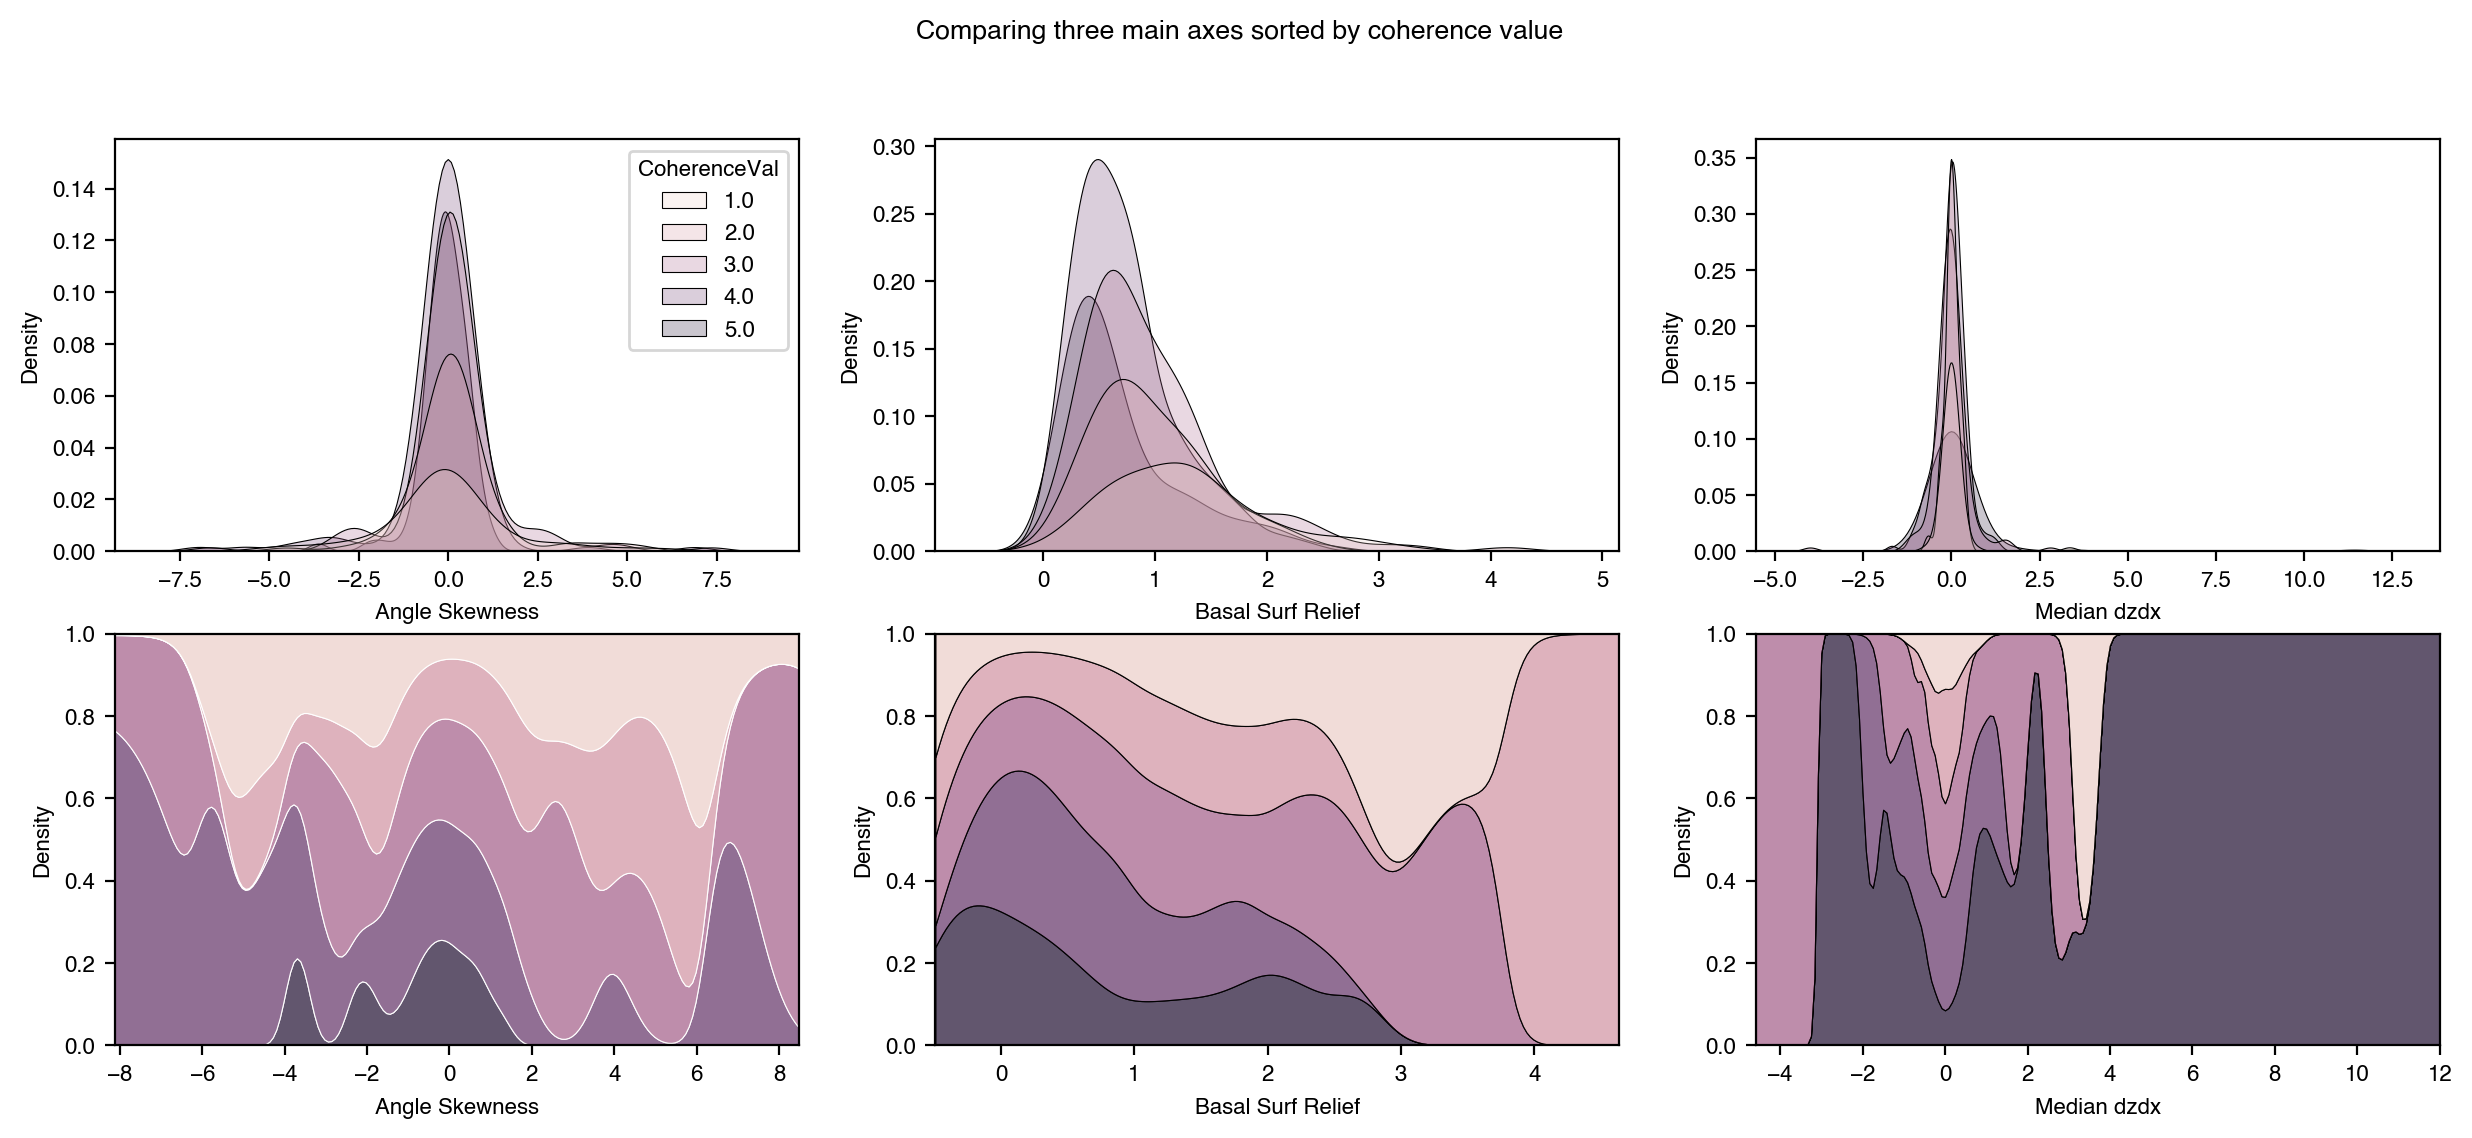

In [13]:
fig, ax = plt.subplots(2, 3, figsize = (15, 6), dpi = 200)
fig.suptitle('Comparing three main axes sorted by coherence value')
skew = sns.kdeplot(allbars['Angle Skewness'], ax = ax[0, 0], hue = allbars['CoherenceVal'], linewidth = .4, fill=True, edgecolor='k')
bsr = sns.kdeplot(allbars['Basal Surf Relief'], ax = ax[0, 1], hue = allbars['CoherenceVal'], linewidth = .4, fill=True, edgecolor='k', legend=False)
va = sns.kdeplot(allbars['Median dzdx'], ax = ax[0, 2], hue = allbars['CoherenceVal'], linewidth = .4, fill=True, edgecolor='k', legend=False)

skew = sns.kdeplot(allbars['Angle Skewness'], ax = ax[1, 0], hue = allbars['CoherenceVal'], multiple = 'fill', linewidth = .4, edgecolor = 'w', legend=False)
bsr = sns.kdeplot(allbars['Basal Surf Relief'], ax = ax[1, 1], hue = allbars['CoherenceVal'], multiple = 'fill', linewidth = .4, legend=False)
va = sns.kdeplot(allbars['Median dzdx'], ax = ax[1, 2], hue = allbars['CoherenceVal'], multiple = 'fill', linewidth = .4, legend=False)

(-4.00635113215132, 11.420205822264)

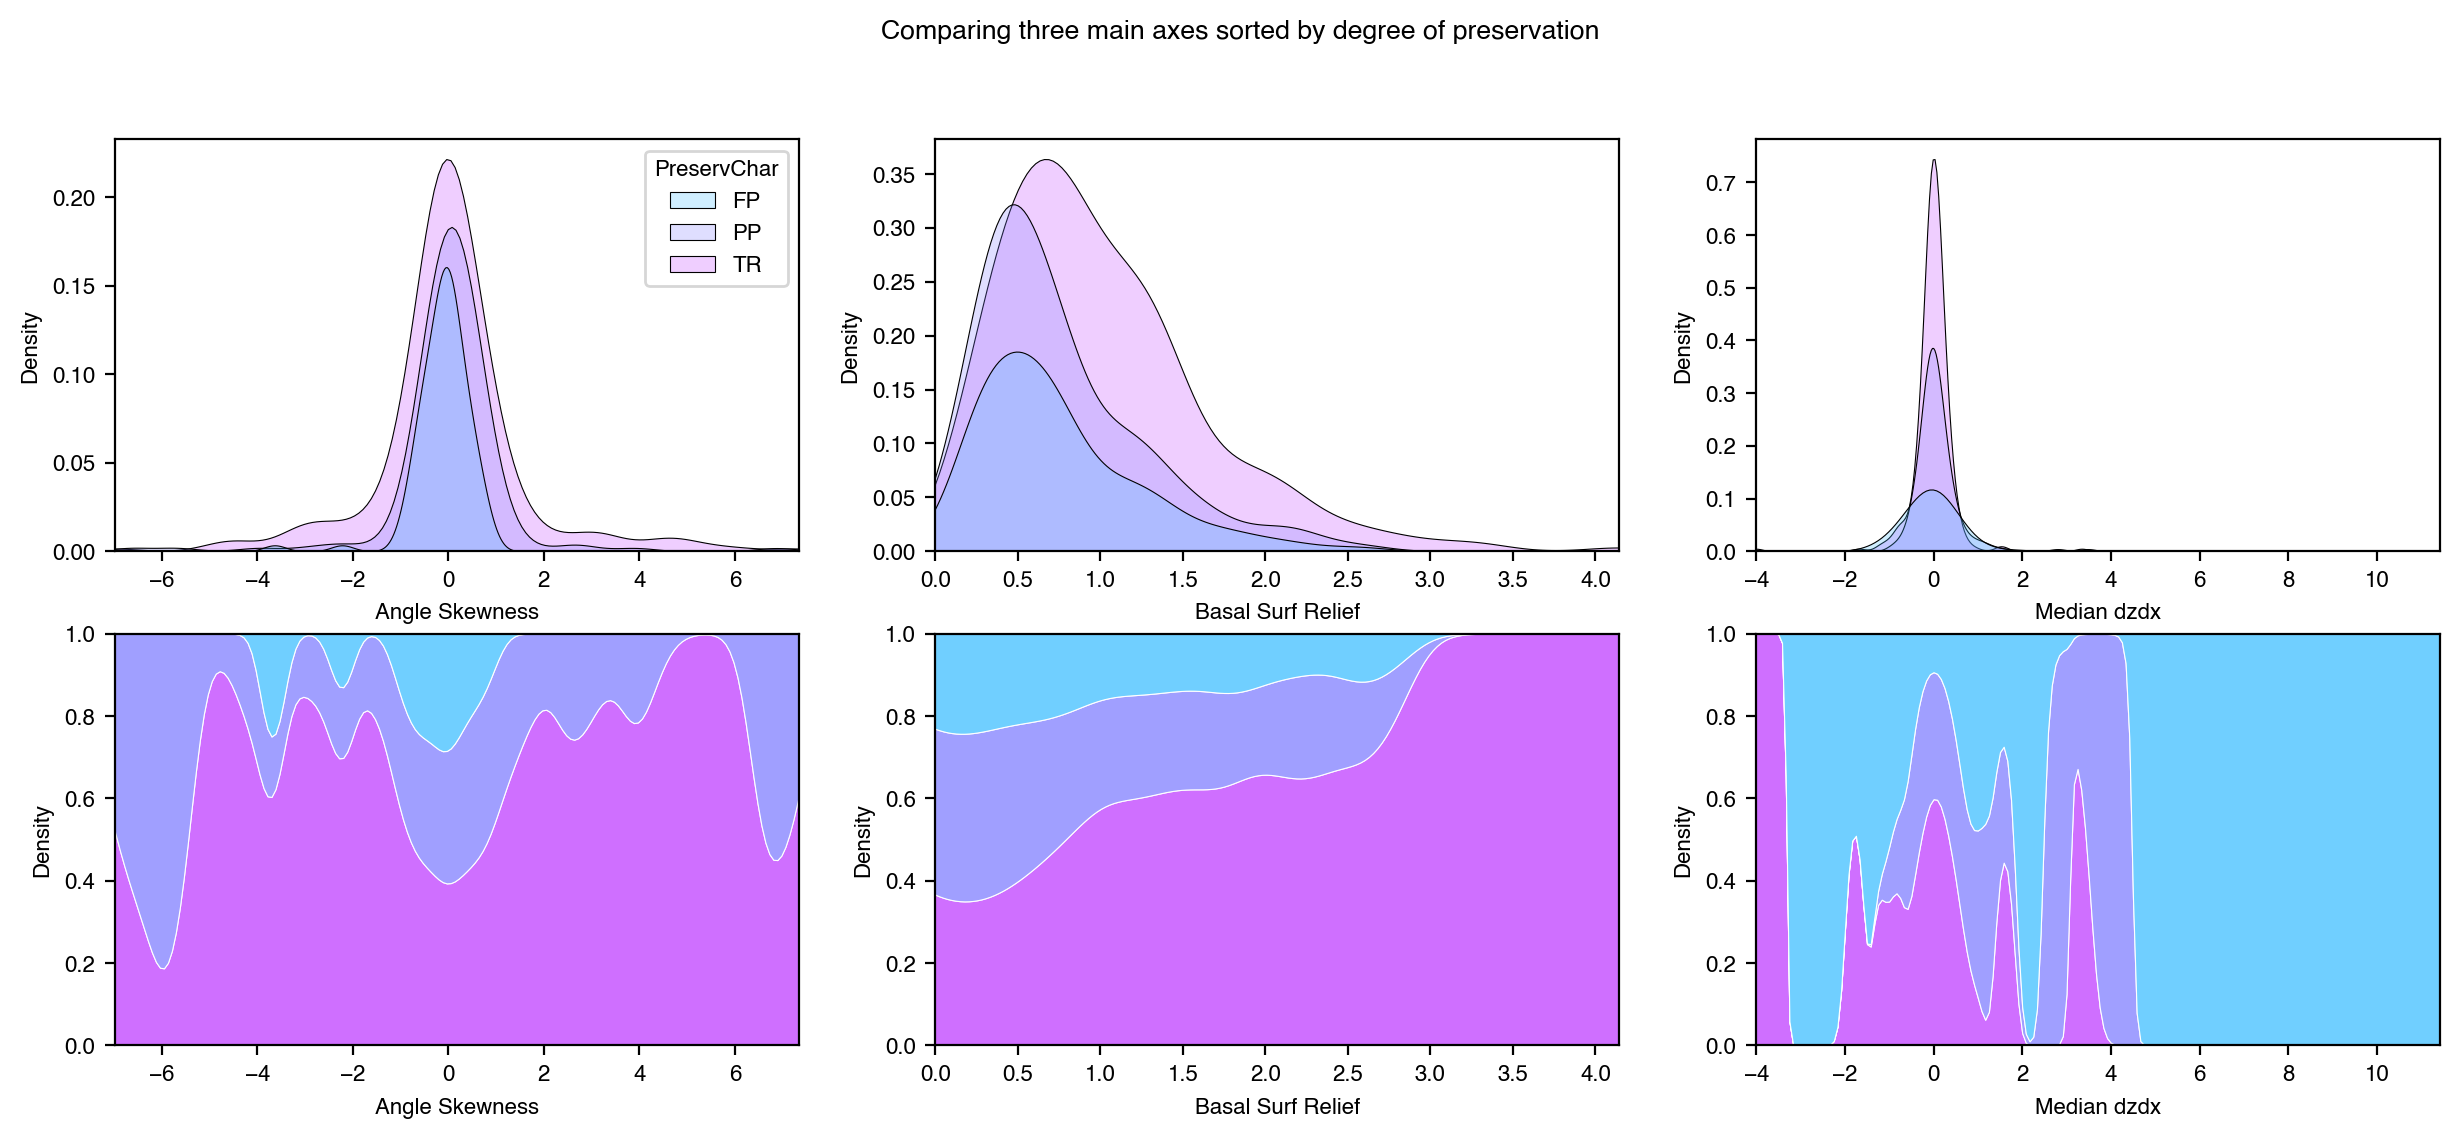

In [14]:
fig, ax = plt.subplots(2, 3, figsize = (15, 6), dpi = 200)
fig.suptitle('Comparing three main axes sorted by degree of preservation')
skew = sns.kdeplot(allbars['Angle Skewness'], ax = ax[0, 0], hue = allbars['PreservChar'], linewidth = .4, fill=True, edgecolor='k', palette = sns.mpl_palette('cool', 3))
bsr = sns.kdeplot(allbars['Basal Surf Relief'], ax = ax[0, 1], hue = allbars['PreservChar'], linewidth = .4, fill=True, edgecolor='k', palette = sns.mpl_palette('cool', 3), legend=False)
va = sns.kdeplot(allbars['Median dzdx'], ax = ax[0, 2], hue = allbars['PreservChar'], linewidth = .4, fill=True, edgecolor='k', palette = sns.mpl_palette('cool', 3), legend=False)

skew = sns.kdeplot(allbars['Angle Skewness'], ax = ax[1, 0], hue = allbars['PreservChar'], multiple = 'fill', linewidth = .4, edgecolor = 'w', palette = sns.mpl_palette('cool', 3), legend=False)
bsr = sns.kdeplot(allbars['Basal Surf Relief'], ax = ax[1, 1], hue = allbars['PreservChar'], multiple = 'fill', linewidth = .4, edgecolor = 'w', palette = sns.mpl_palette('cool', 3), legend=False)
va = sns.kdeplot(allbars['Median dzdx'], ax = ax[1, 2], hue = allbars['PreservChar'], multiple = 'fill', linewidth = .4, edgecolor = 'w', palette = sns.mpl_palette('cool', 3), legend=False)

ax[1, 0].set_xlim(allbars['Angle Skewness'].min(), allbars['Angle Skewness'].max())
ax[1, 1].set_xlim(allbars['Basal Surf Relief'].min(), allbars['Basal Surf Relief'].max())
ax[1, 2].set_xlim(allbars['Median dzdx'].min(), allbars['Median dzdx'].max())

ax[0, 0].set_xlim(allbars['Angle Skewness'].min(), allbars['Angle Skewness'].max())
ax[0, 1].set_xlim(allbars['Basal Surf Relief'].min(), allbars['Basal Surf Relief'].max())
ax[0, 2].set_xlim(allbars['Median dzdx'].min(), allbars['Median dzdx'].max())

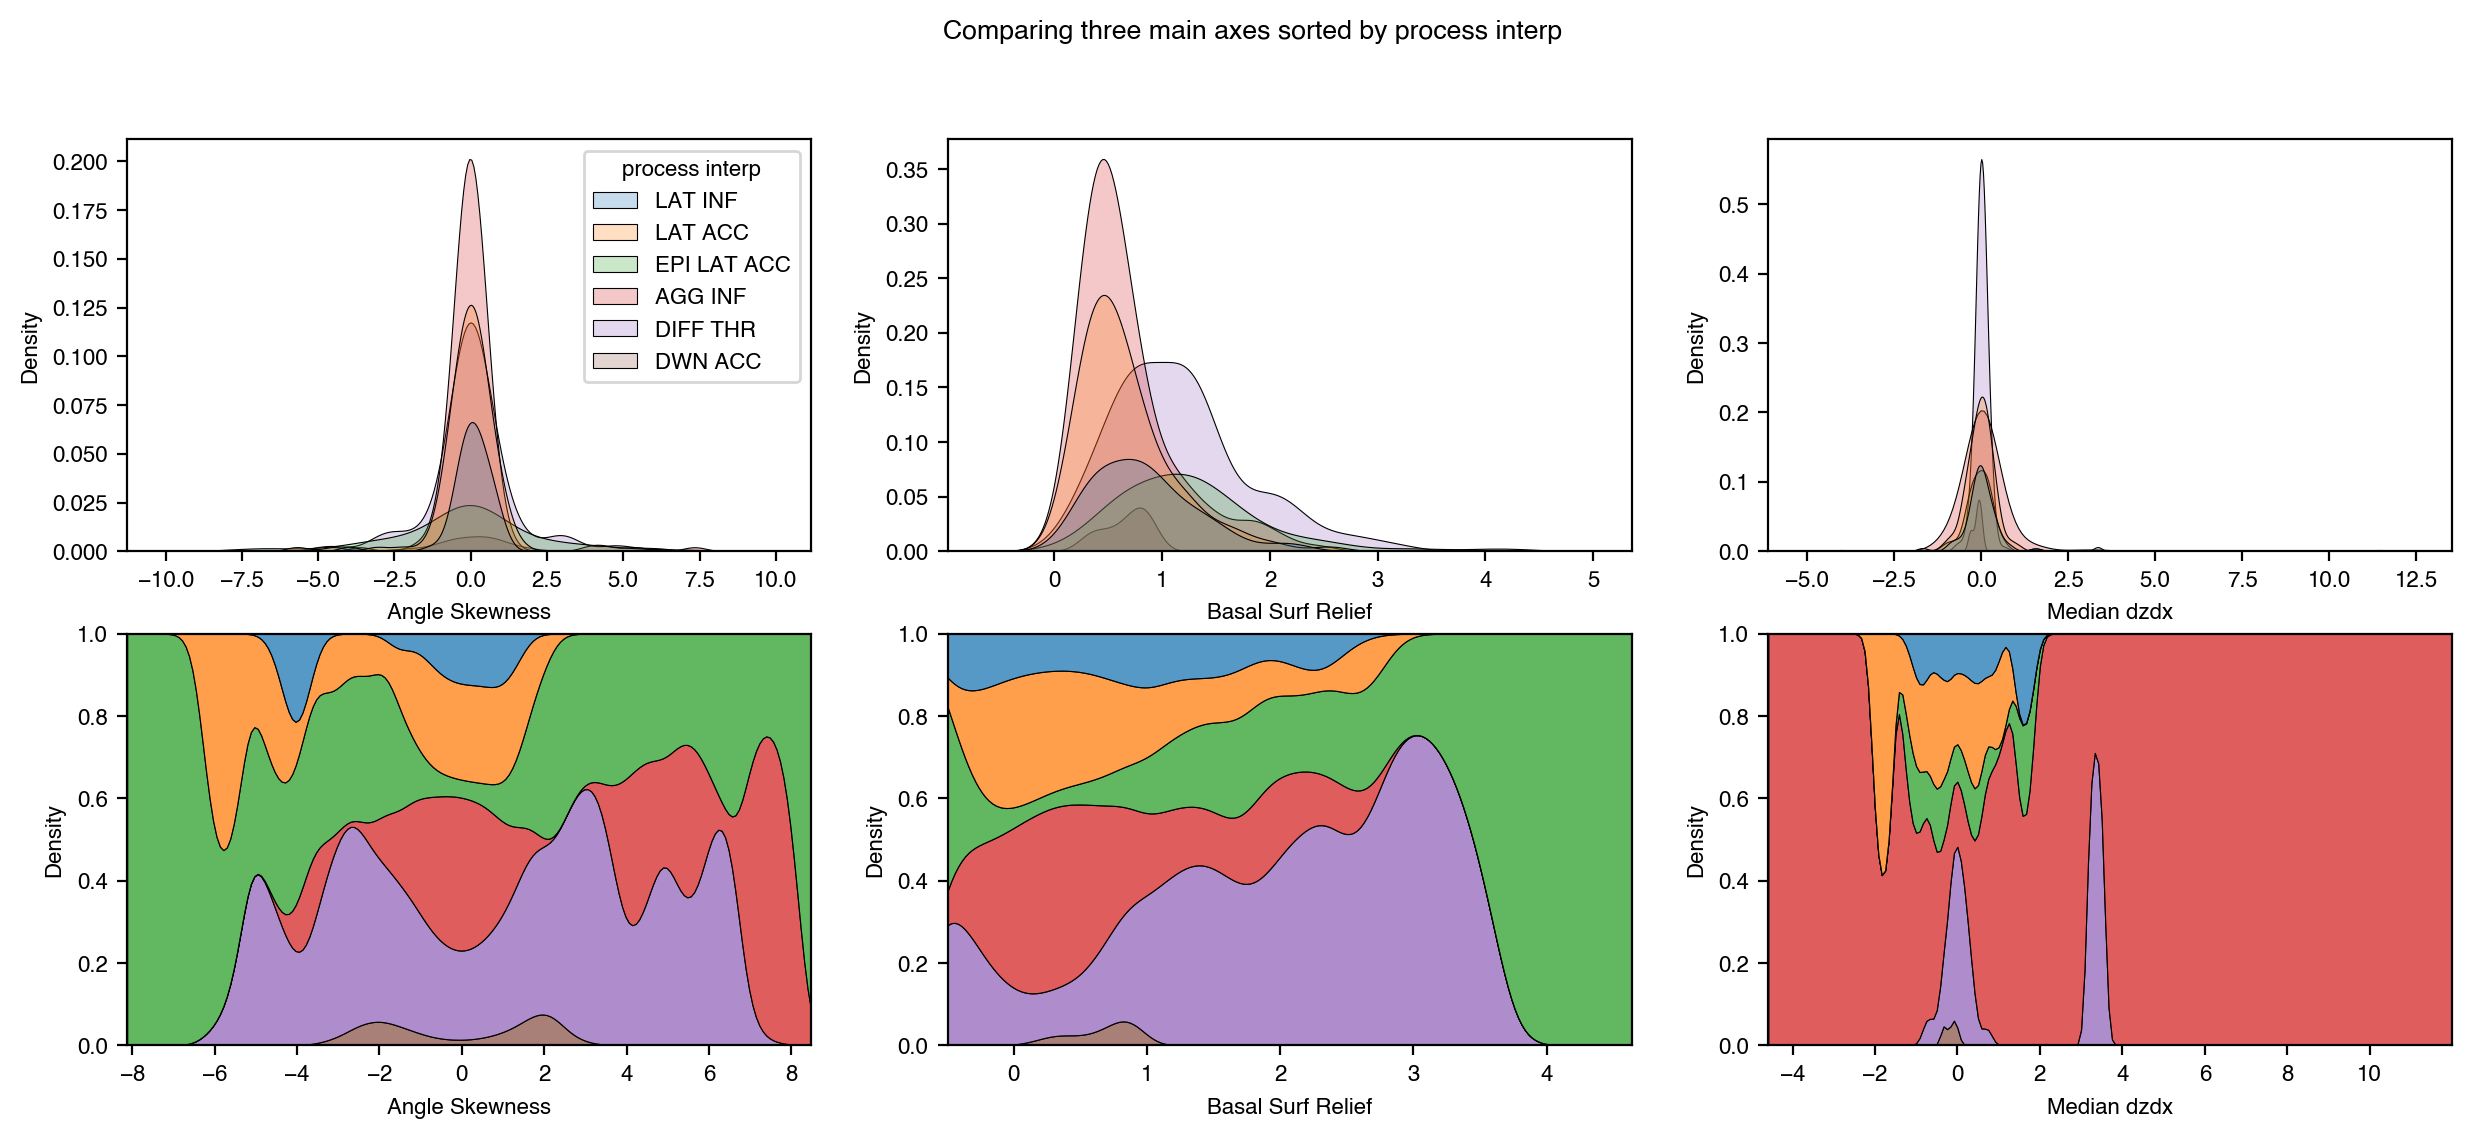

In [15]:
warn_singular=False
fig, ax = plt.subplots(2, 3, figsize = (15, 6), dpi = 200)
fig.suptitle('Comparing three main axes sorted by process interp')
skew = sns.kdeplot(allbars['Angle Skewness'], ax = ax[0, 0], hue = allbars['process interp'], linewidth = .4, fill=True, edgecolor='k')
bsr = sns.kdeplot(allbars['Basal Surf Relief'], ax = ax[0, 1], hue = allbars['process interp'], linewidth = .4, fill=True, edgecolor='k', legend=False)
va = sns.kdeplot(allbars['Median dzdx'], ax = ax[0, 2], hue = allbars['process interp'], linewidth = .4, fill=True, edgecolor='k', legend=False)

skew = sns.kdeplot(allbars['Angle Skewness'], ax = ax[1, 0], hue = allbars['process interp'], multiple = 'fill', linewidth = .4, edgecolor = 'k', legend=False)
bsr = sns.kdeplot(allbars['Basal Surf Relief'], ax = ax[1, 1], hue = allbars['process interp'], multiple = 'fill', linewidth = .4, legend=False)
va = sns.kdeplot(allbars['Median dzdx'], ax = ax[1, 2], hue = allbars['process interp'], multiple = 'fill', linewidth = .4, legend=False)

<AxesSubplot:xlabel='process interp', ylabel='Count'>

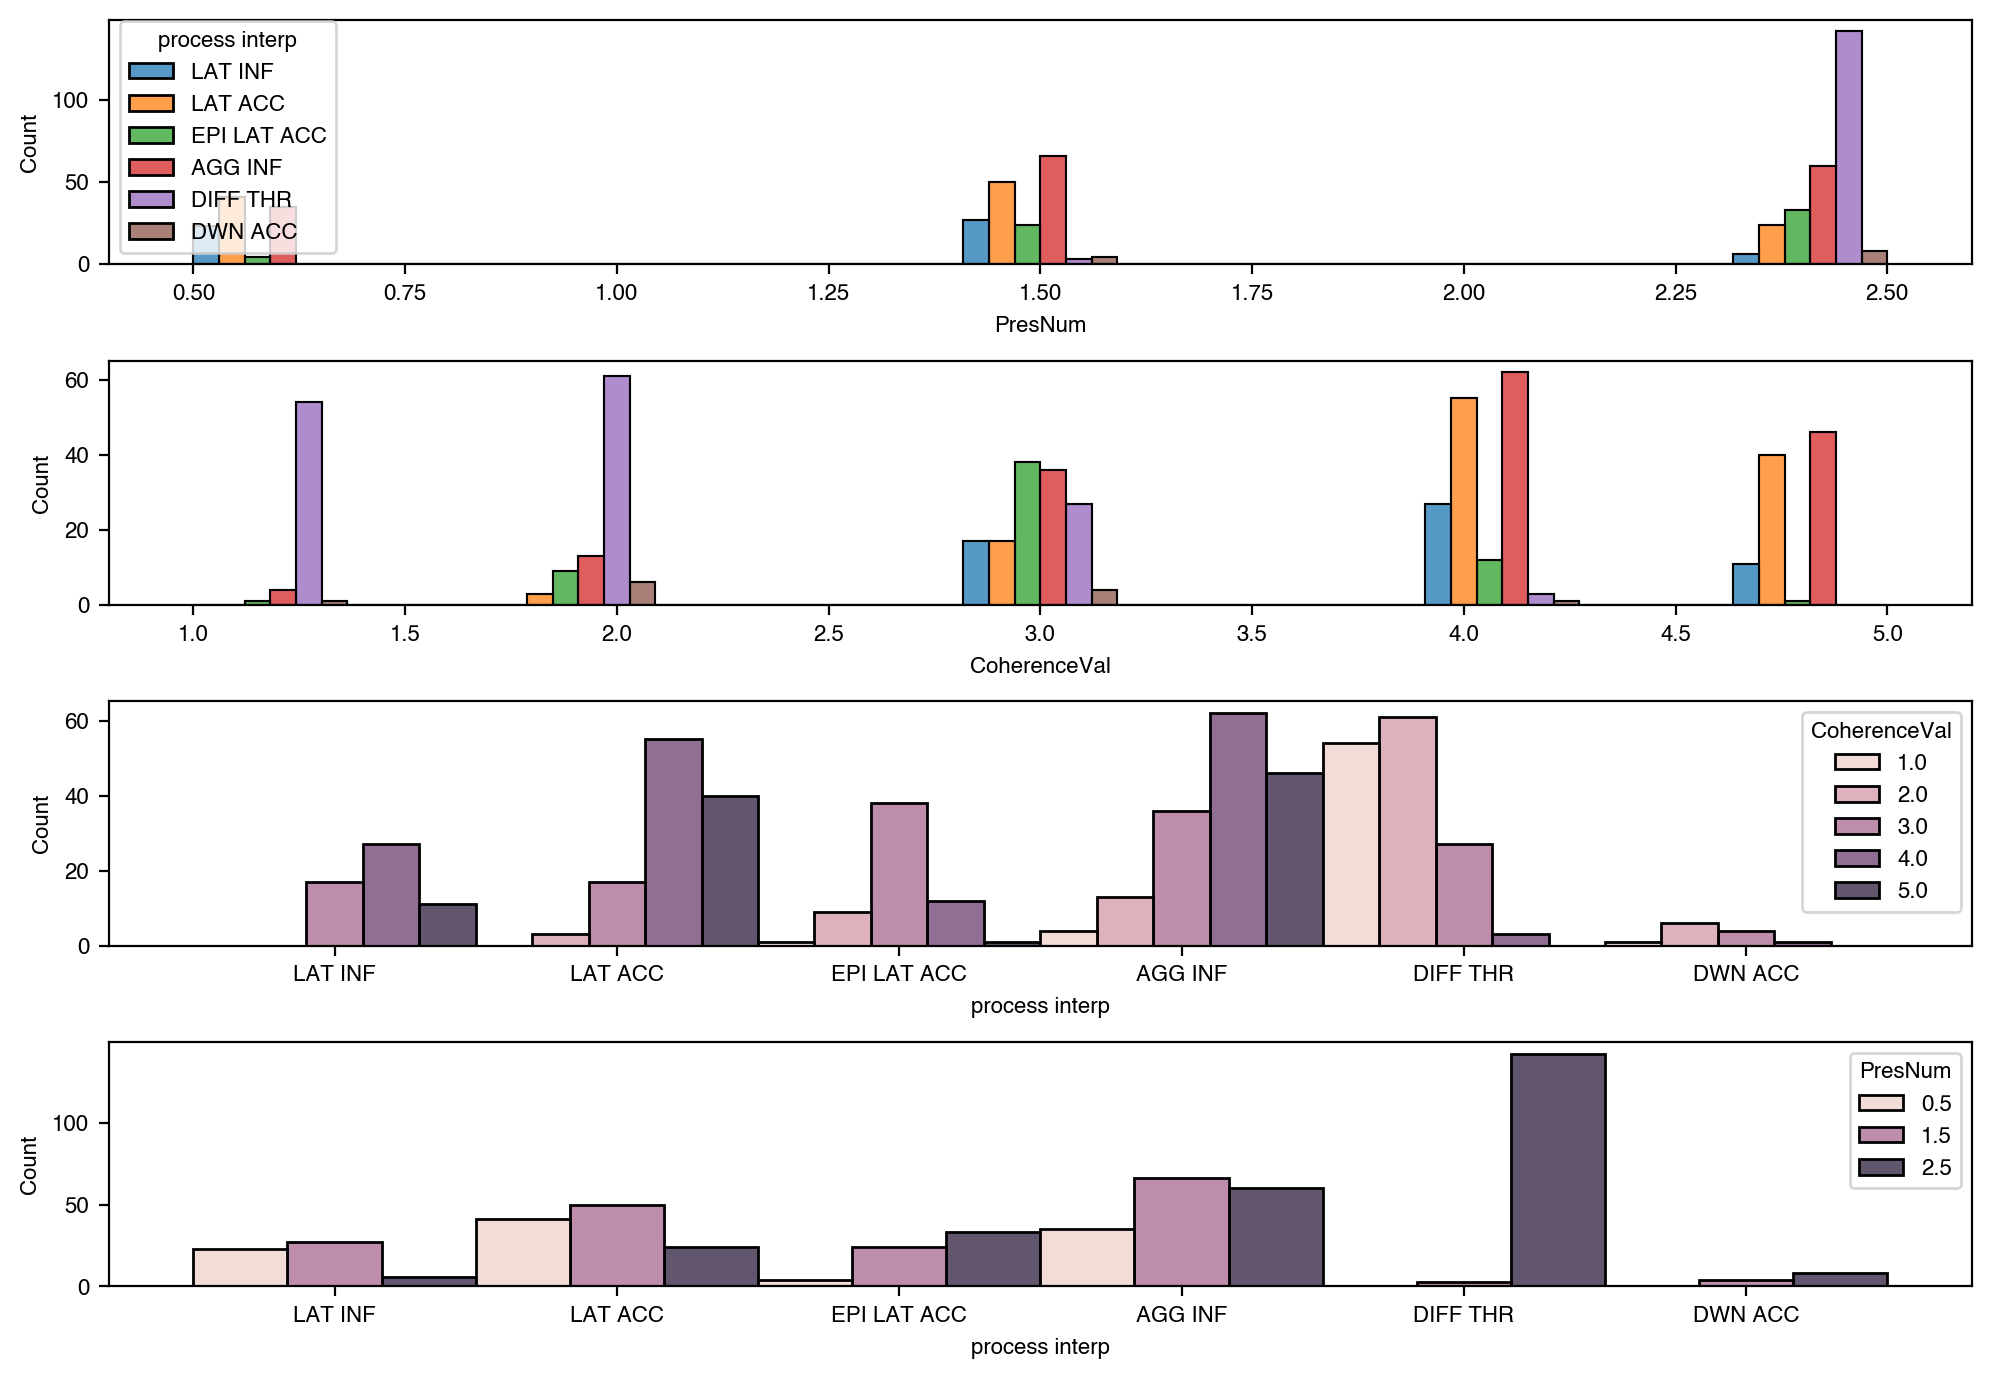

In [16]:
fig, ax = plt.subplots(4, figsize = (10, 7), dpi = 200, tight_layout=True)

#sns.histplot(allbars['PresNum'], bins = [0, 1, 2, 3])#, hue = allbars['process interp'], linewidth = .4, edgecolor = 'k')
sns.histplot(data=allbars, x = 'PresNum', hue = 'process interp', multiple='dodge', ax = ax[0])
sns.histplot(data=allbars, x = 'CoherenceVal', hue = 'process interp', multiple='dodge', ax = ax[1], legend = False)
sns.histplot(data=allbars, x = 'process interp', hue = 'CoherenceVal', multiple='dodge', ax = ax[2], legend = True)
sns.histplot(data=allbars, x = 'process interp', hue = 'PresNum', multiple='dodge', ax = ax[3], legend = True)

##### Trying to make that plot of the channel planform and the abundance of each type of bar in the section, compared to widening rates

In [82]:
## import widening rates
profile_master = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh210km-profile.npy') ## channel profile for each timestep
print(profile_master.shape)
# 0 = ilocs, starts at 0m, every 10m
# 1 = right bank
# 2 = left bank
# 3 = rb displacement (from timestep before)
# 4 = lb displacement (from timestep before)
# 5 = rb widening rate
# 6 = lb widening rate (2 hr intervals)
interval = 2
cropint = 5
pm_10 = copy.deepcopy(profile_master[:, :, ::cropint])
total_wr = ((pm_10[:, 2, 1:]-pm_10[:, 1, 1:])-(pm_10[:, 2, :-1]-pm_10[:, 1, :-1]))/(interval*cropint) ##every 10 hours
#total_wr = ((profile_master[:, 2, 1:]-profile_master[:, 1, 1:])-(profile_master[:, 2, :-1]-profile_master[:, 1, :-1]))/2

(1001, 7, 382)


In [83]:
# test = np.transpose(profile_master, (profile_master.shape[2], profile_master.shape[1], profile_master.shape[0]))
byiloc = np.transpose(profile_master, (2, 1, 0)) ## profiles array transposed so every page/sheet is one iloc

find rows where a value = True `allbars[allbars['iloc']==150]`

print headers
`df.columns()`

In [86]:
iloc150 = allbars[allbars['iloc']==150]
widen150 = profile_master[:, :, 150]

Text(0, 0.5, 'Widening Rate\n (2hr intervals)')

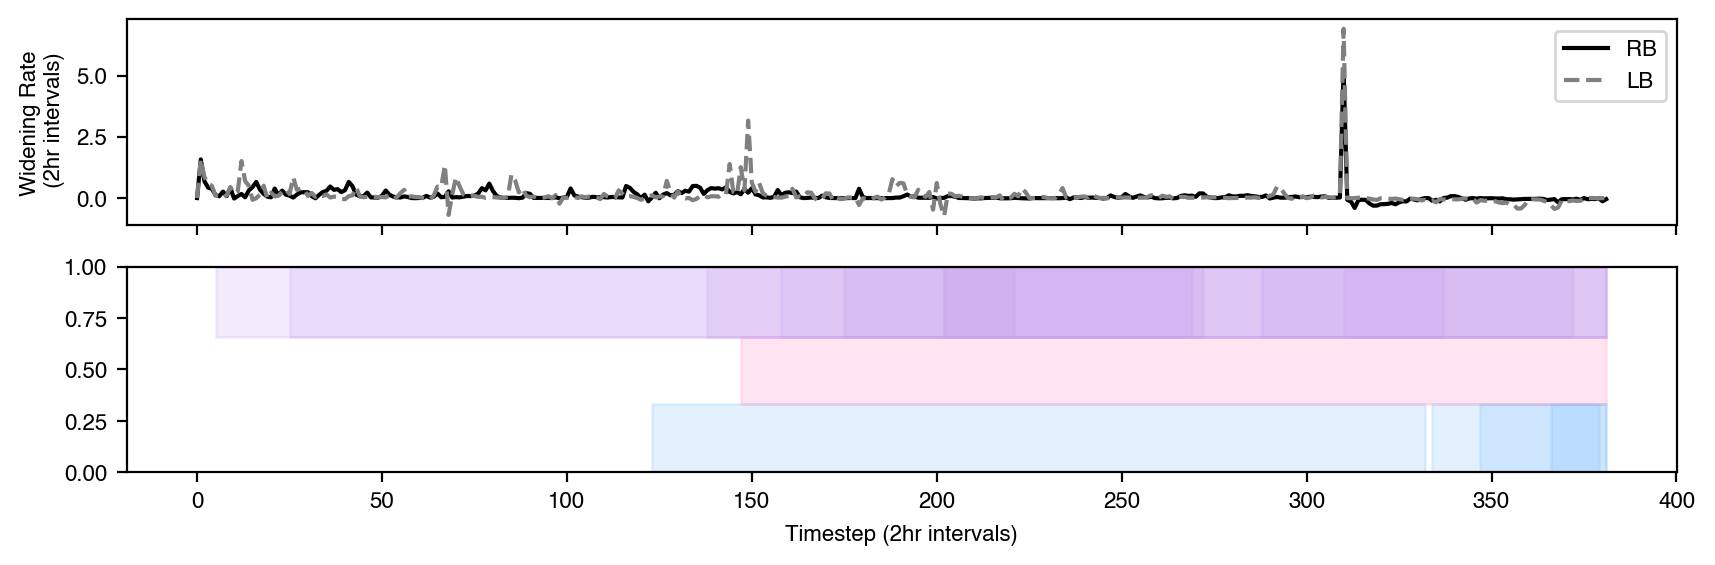

In [87]:
# plt.plot(widen150[:, 0])
fig, ax = plt.subplots(2, figsize = (10, 3), dpi = 200, sharex = True)
ax[0].plot(profile_master[150, 5, :], 'k', label = 'RB') ## this is the indexing to get one row
ax[0].plot(profile_master[150, 6, :], color = 'grey', ls = '--', label = 'LB') 
ax[0].legend()
for i in range (0, len(iloc150)):
    if iloc150.iloc[i]['PreservChar']=='FP':
        ax[1].axvspan(iloc150.iloc[i]['StartTime'], iloc150.iloc[i]['EndTime'], ymin = 0, ymax= 0.33, color = 'xkcd:sky blue', alpha = 0.2)
    elif iloc150.iloc[i]['PreservChar']=='PP':
        ax[1].axvspan(iloc150.iloc[i]['StartTime'], iloc150.iloc[i]['EndTime'], ymin = 0.33, ymax = 0.66, color = 'xkcd:pink', alpha = 0.2)
    elif iloc150.iloc[i]['PreservChar']=='TR':
        ax[1].axvspan(iloc150.iloc[i]['StartTime'], iloc150.iloc[i]['EndTime'], ymin = 0.66, ymax = 1, color = 'xkcd:lavender', alpha = 0.2)
        
ax[1].set_xlabel('Timestep (2hr intervals)')
ax[0].set_ylabel('Widening Rate\n (2hr intervals)')

Text(0.5, 0, 'Start Time')

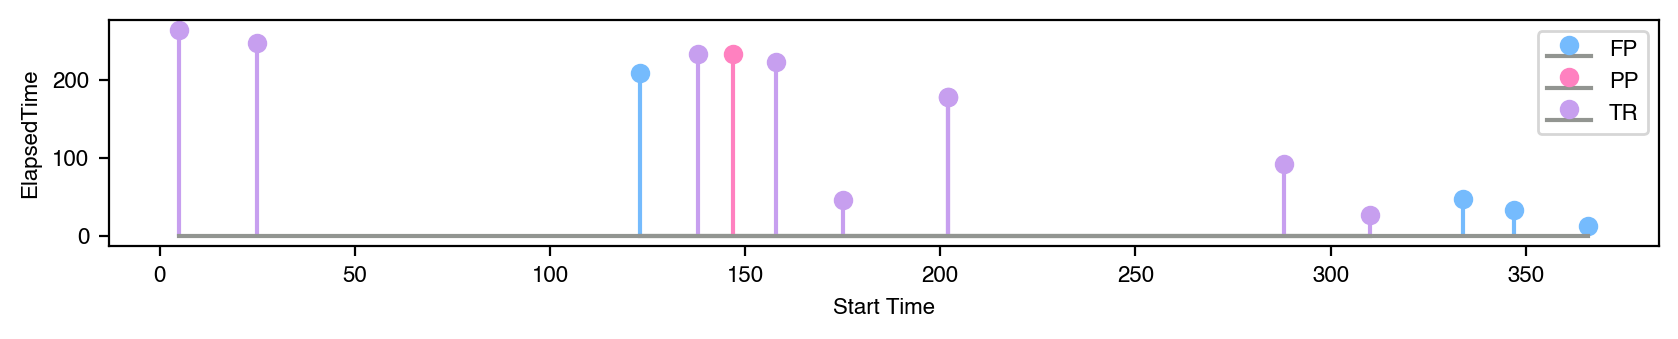

In [88]:
plt.figure(figsize = (10, 1.5), dpi = 200)

mkrfp, stmfp, basefp = plt.stem(iloc150[iloc150['PreservChar']=='FP']['StartTime'], iloc150[iloc150['PreservChar']=='FP']['ElapsedTime'], linefmt = 'xkcd:sky blue', label = 'FP', basefmt = 'xkcd:grey')
plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))

mkrpp, stmpp, basepp = plt.stem(iloc150[iloc150['PreservChar']=='PP']['StartTime'], iloc150[iloc150['PreservChar']=='PP']['ElapsedTime'], linefmt = 'xkcd:pink', label = 'PP', basefmt = 'xkcd:grey')
plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))

mkrtr, stmtr, basetr = plt.stem(iloc150[iloc150['PreservChar']=='TR']['StartTime'], iloc150[iloc150['PreservChar']=='TR']['ElapsedTime'], linefmt = 'xkcd:lavender', label = 'TR', basefmt = 'xkcd:grey')
plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))

plt.legend()
plt.ylabel('ElapsedTime')
plt.xlabel('Start Time')

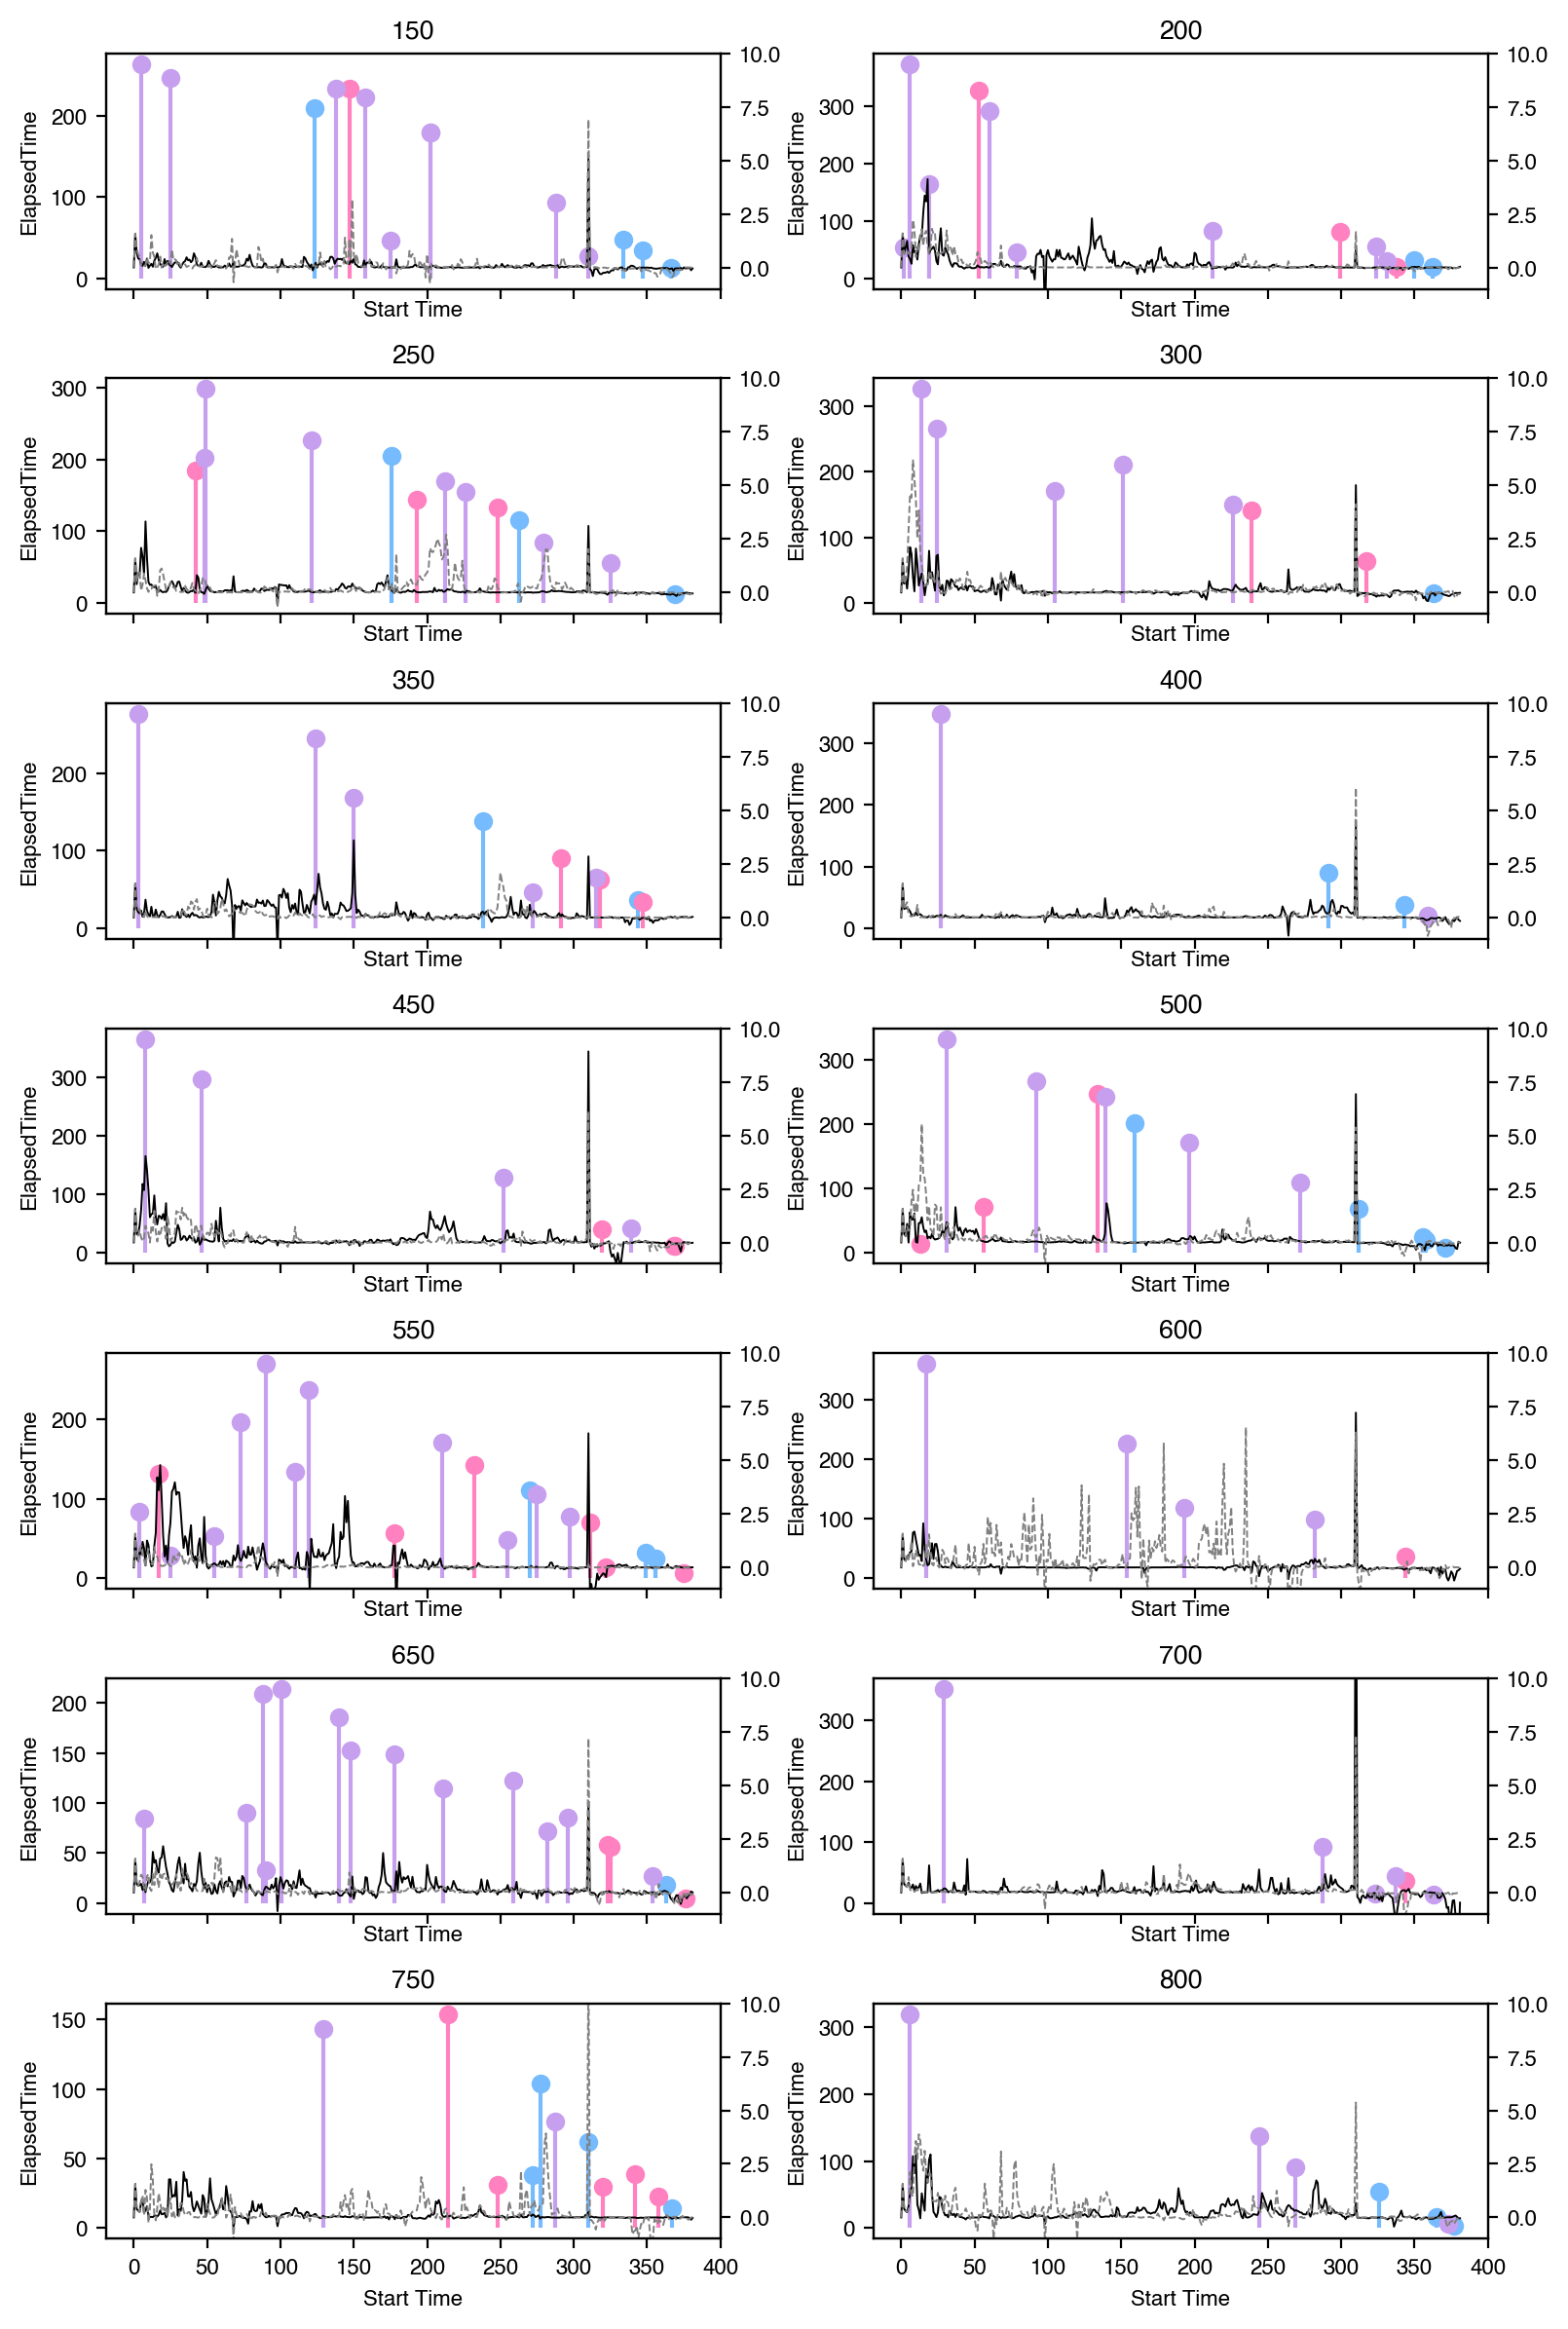

In [89]:
ilocs = np.arange(150, 850, 50)

fig, ax = plt.subplots(len(ilocs)//2, 2, figsize = (8, 12), dpi = 200, sharex = True, tight_layout =True)
ax = ax.ravel()
for idx, i in enumerate(ilocs):
    blank = allbars[allbars['iloc']==i]
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['PreservChar']=='FP']['StartTime'], blank[blank['PreservChar']=='FP']['ElapsedTime'], linefmt = 'xkcd:sky blue', label = 'FP', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['PreservChar']=='PP']['StartTime'], blank[blank['PreservChar']=='PP']['ElapsedTime'], linefmt = 'xkcd:pink', label = 'PP', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['PreservChar']=='TR']['StartTime'], blank[blank['PreservChar']=='TR']['ElapsedTime'], linefmt = 'xkcd:lavender', label = 'TR', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    ax[idx].set_title(i)
    ax2 = ax[idx].twinx()
    ax2.plot(profile_master[i, 5, :], 'k', label = 'RB', lw = 0.7, zorder=0) ## this is the indexing to get one row
    ax2.plot(profile_master[i, 6, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0) 
    ax2.set_ylim(-1, 10)
    ax[idx].set_ylabel('ElapsedTime')
    ax[idx].set_xlabel('Start Time')

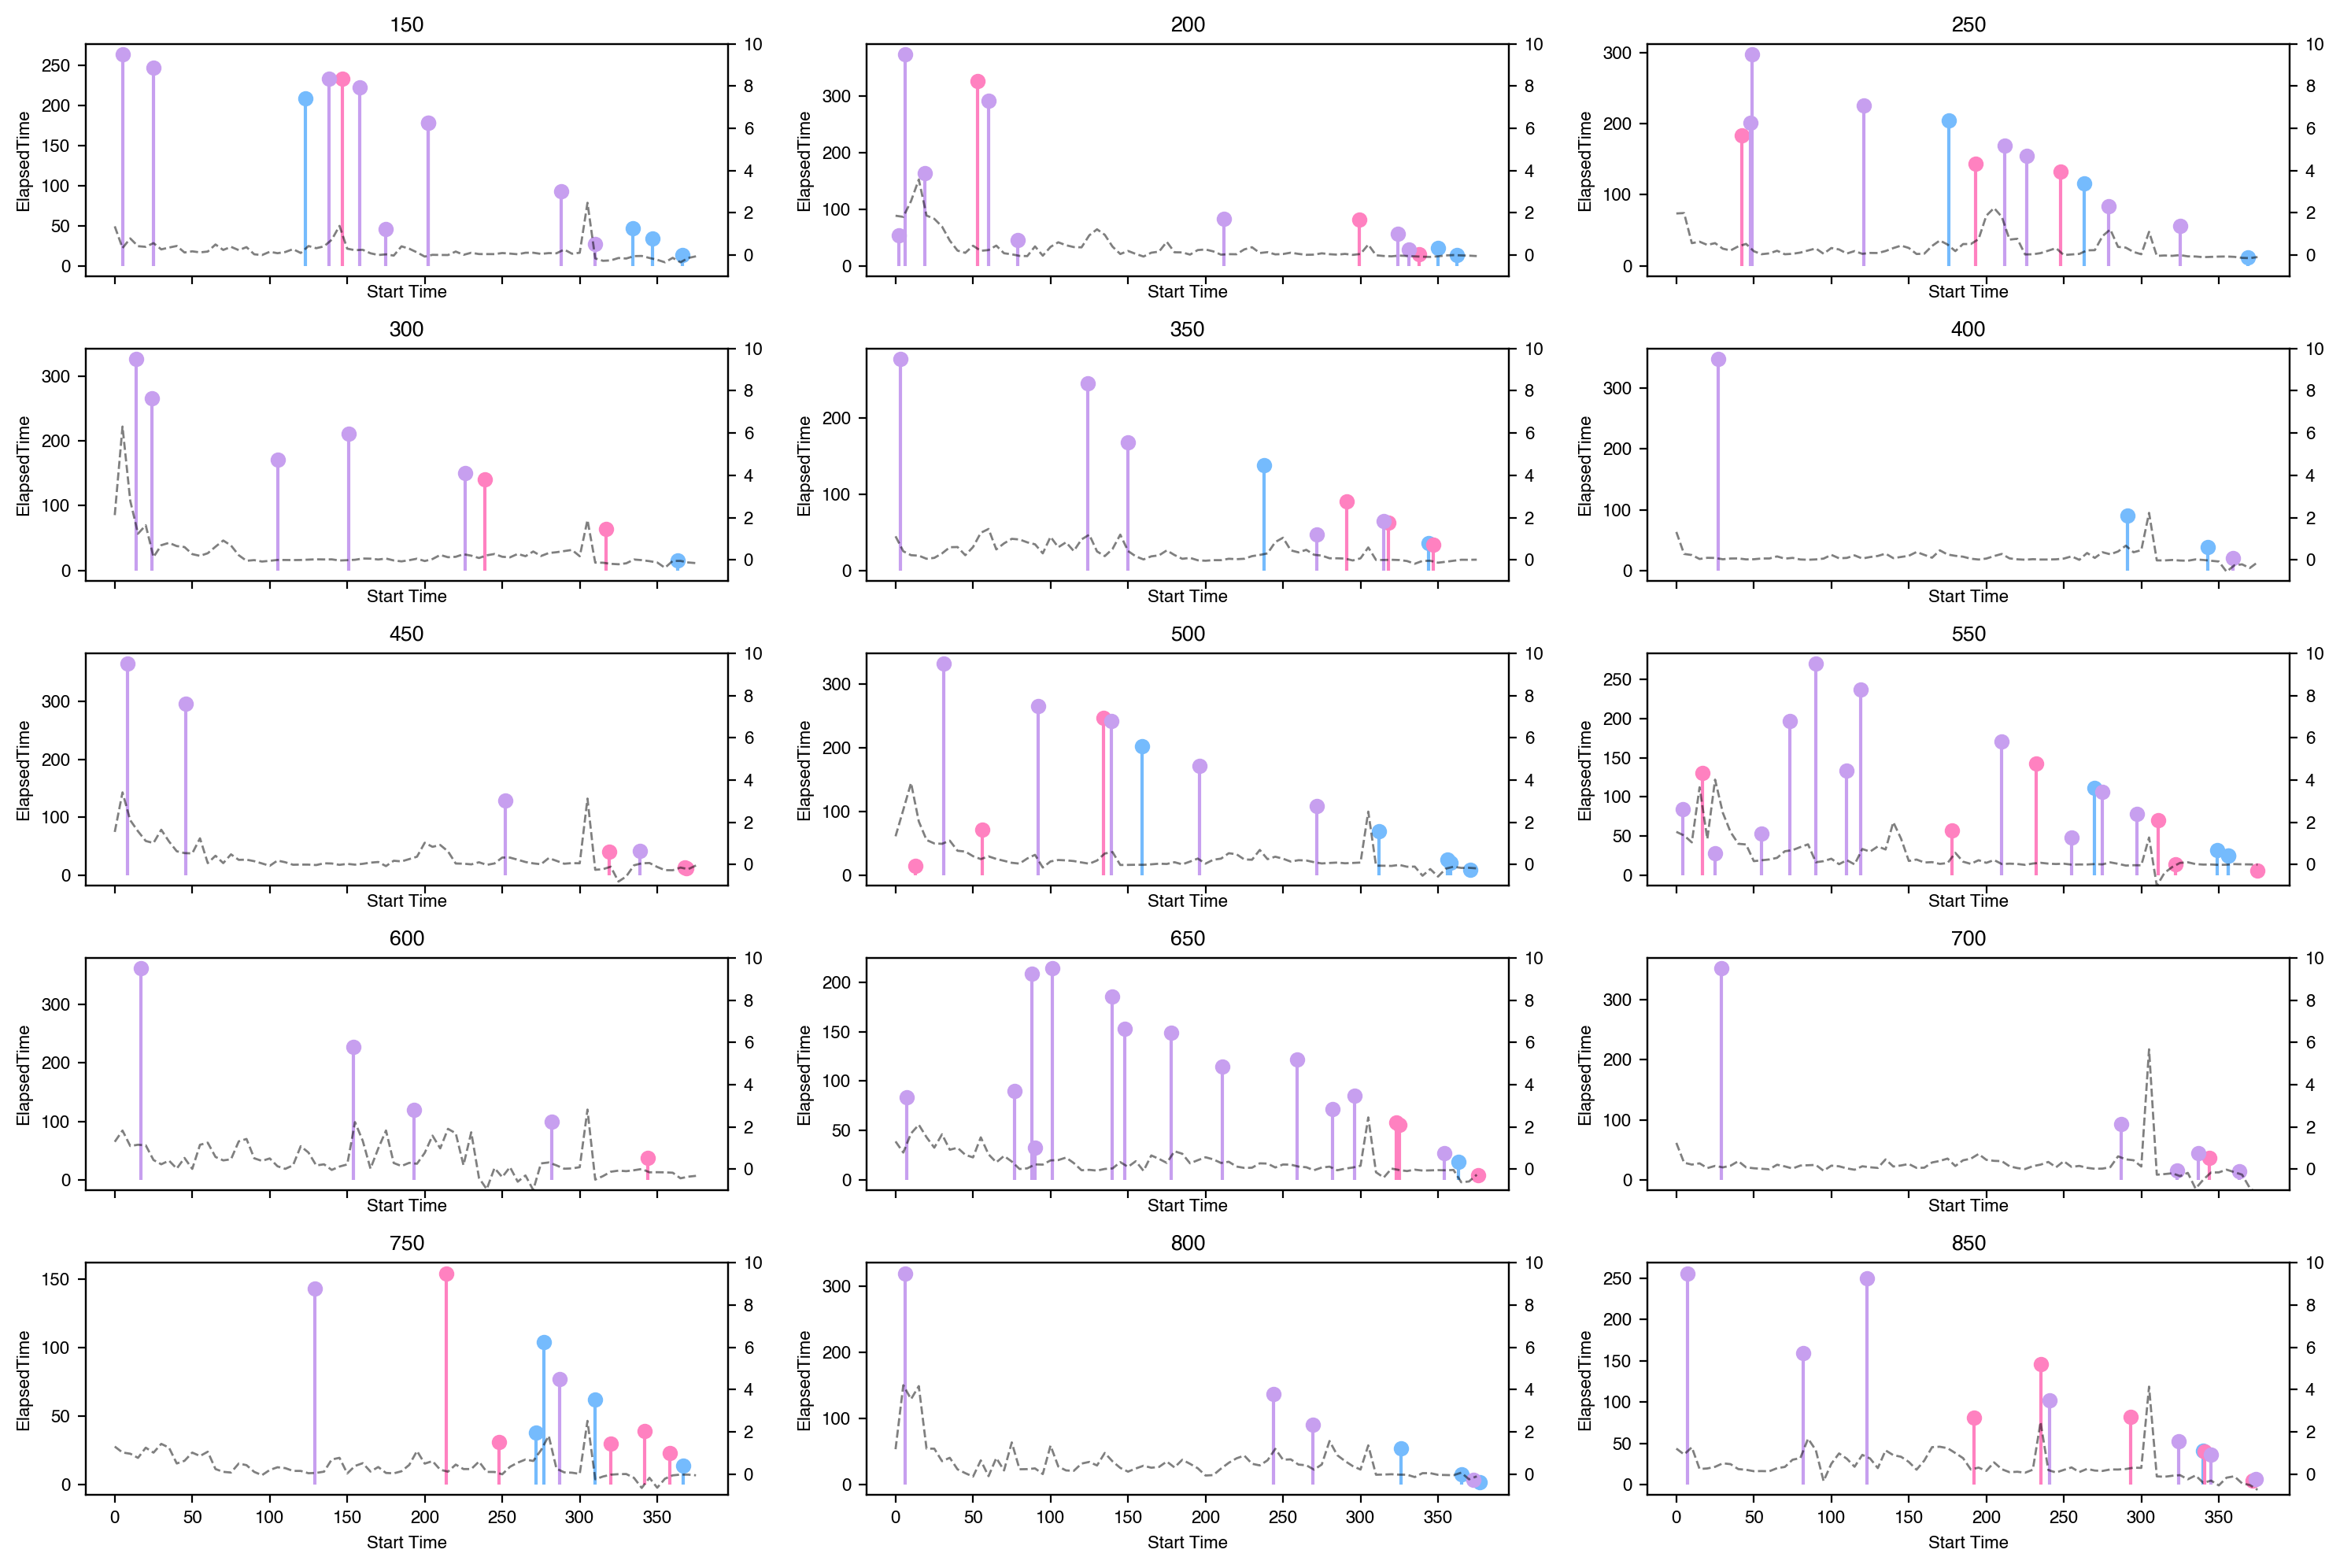

In [90]:
ilocs = np.arange(150, 900, 50)
times = np.arange(total_wr.shape[1])*cropint
fig, ax = plt.subplots(len(ilocs)//3, 3, figsize = (15, 10), dpi = 200, sharex = True, tight_layout =True)
ax = ax.ravel()
for idx, i in enumerate(ilocs):
    
    ax2 = ax[idx].twinx()
    ax2.plot(times, total_wr[i, :], 'k--', label = 'RB', lw = 1, zorder=0, alpha = .5) ## this is the indexing to get one row

    ax2.set_ylim(-1, 10)
    blank = allbars[allbars['iloc']==i]
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['PreservChar']=='FP']['StartTime'], blank[blank['PreservChar']=='FP']['ElapsedTime'], linefmt = 'xkcd:sky blue', label = 'FP', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['PreservChar']=='PP']['StartTime'], blank[blank['PreservChar']=='PP']['ElapsedTime'], linefmt = 'xkcd:pink', label = 'PP', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['PreservChar']=='TR']['StartTime'], blank[blank['PreservChar']=='TR']['ElapsedTime'], linefmt = 'xkcd:lavender', label = 'TR', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    ax[idx].set_title(i)

    ax[idx].set_ylabel('ElapsedTime')
    ax[idx].set_xlabel('Start Time')

## Cross Plots, don't run

<Figure size 1080x1080 with 0 Axes>

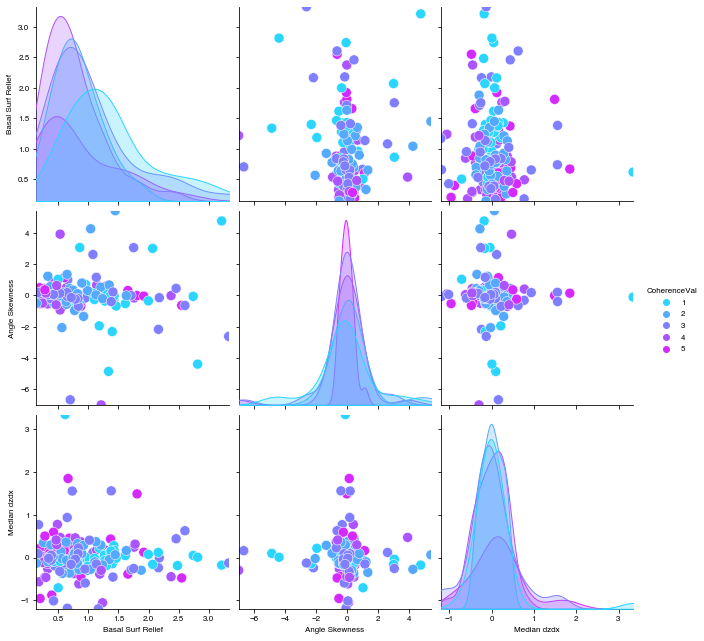

In [18]:
plt.figure(figsize = (15, 15))
pplot = sns.pairplot(allbars,
                     plot_kws=dict(marker="o", linewidth=0.5, s = 100, edgecolor = 'w'),
                     vars = ['Basal Surf Relief', 'Angle Skewness', 'Median dzdx'], hue = 'CoherenceVal', height = 3, aspect = 1, palette = sns.mpl_palette('cool', 5))
snsvars = ['Basal Surf Relief', 'Angle Skewness', 'Median dzdx']
for i, v in enumerate(snsvars):
    pplot.axes[-1, i].set(xlim=(allbars[v].min(), allbars[v].max()))

for i, v in enumerate(snsvars):
    pplot.axes[i, 0].set(ylim=(allbars[v].min(), allbars[v].max()))

# pplot.set(xlim=(0, None))

# pplot.set(xlim=(0, None))
# pplot.axes[-1, 0].set(xlim=(0, 600))
# plt.savefig(f'{savefilesto}/pairplot-cbbsr-bin.png', dpi = 200)

<Figure size 1080x1080 with 0 Axes>

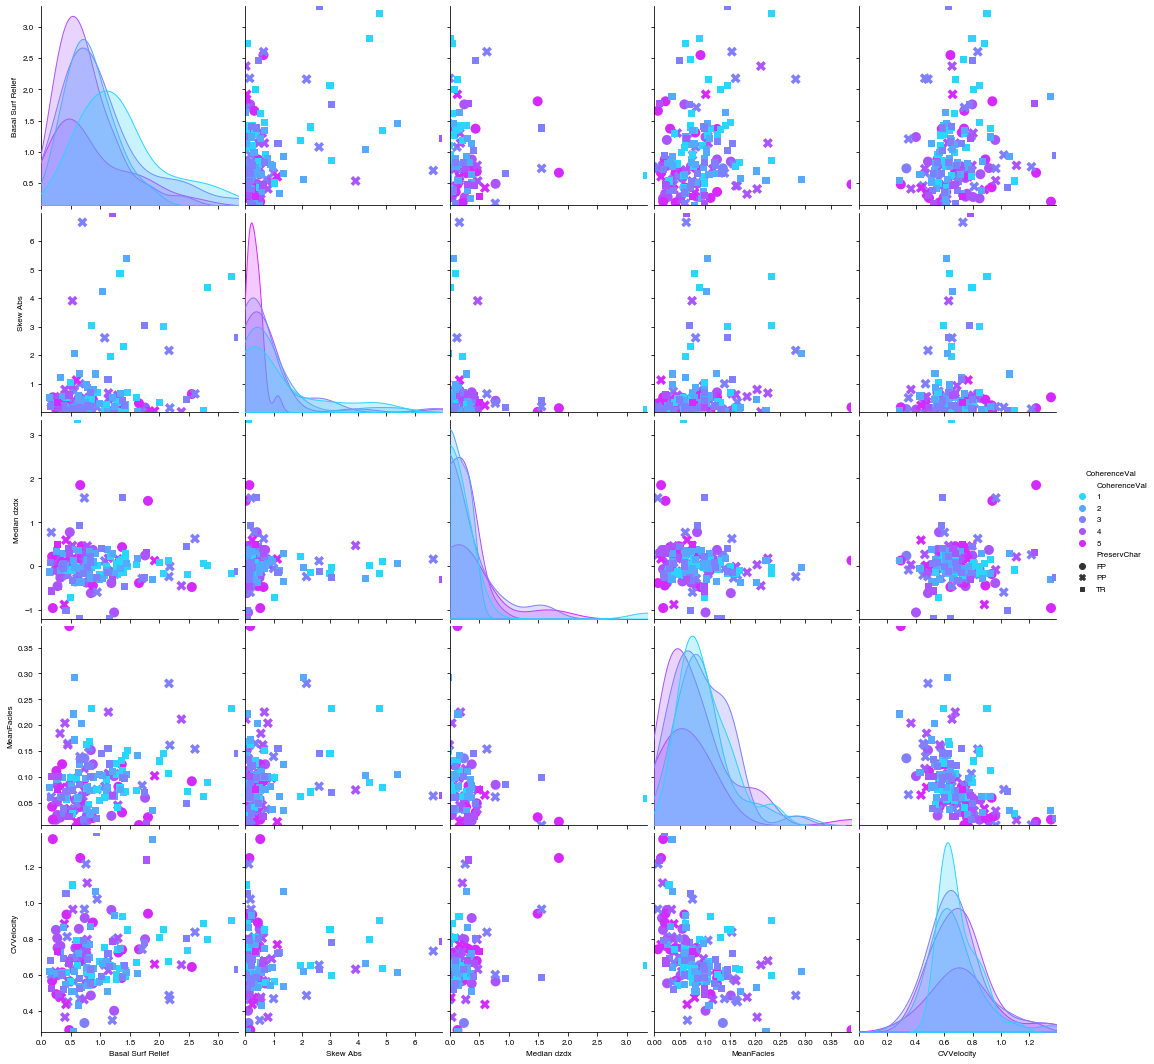

In [16]:
plt.figure(figsize = (15, 15))
pplot = sns.pairplot(allbars,
                     plot_kws=dict(style = allbars['PreservChar'], linewidth=0, s = 100, edgecolor = 'w'),
                     vars = ['Basal Surf Relief', 'Skew Abs', 'Median dzdx', 'MeanFacies', 'CVVelocity'], hue = 'CoherenceVal', height = 3, aspect = 1, palette = sns.mpl_palette('cool', 5))
snsvars = ['Basal Surf Relief', 'Skew Abs', 'Median dzdx', 'MeanFacies', 'CVVelocity']
for i, v in enumerate(snsvars):
    pplot.axes[-1, i].set(xlim=(0, allbars[v].max()))

for i, v in enumerate(snsvars):
    pplot.axes[i, 0].set(ylim=(allbars[v].min(), allbars[v].max()))

# pplot.map_lower(sns.kdeplot, levels=2, color="w")

# pplot.set(xlim=(0, None))
# pplot.axes[-1, 0].set(xlim=(0, 600))
# plt.savefig(f'{savefilesto}/pairplot-cbbsr-bin.png', dpi = 200)

<Figure size 1080x1080 with 0 Axes>

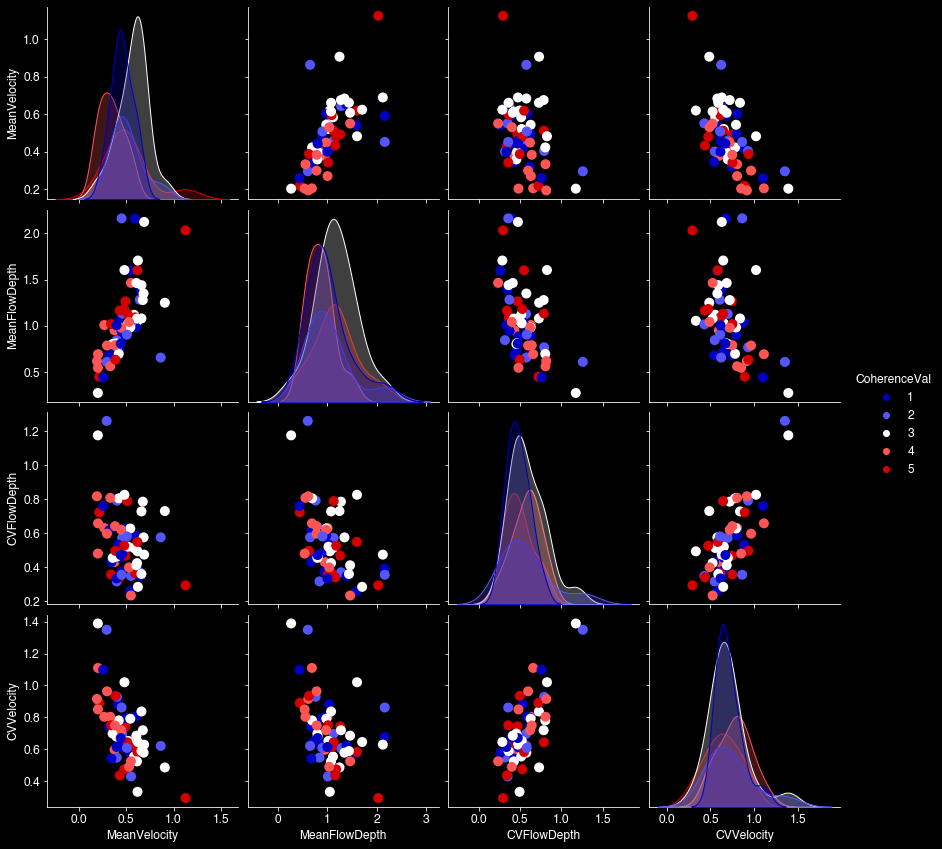

In [152]:
plt.figure(figsize = (15, 15))
with plt.style.context('dark_background'):
    sns.pairplot(allbars, plot_kws=dict(marker="o", linewidth=0, s = 100, edgecolor = 'w'), 
                 vars = ['MeanVelocity', 'MeanFlowDepth', 'CVFlowDepth', 'CVVelocity'],
                hue = 'CoherenceVal', height = 3, aspect = 1, palette = sns.mpl_palette('seismic', 5))
    snsvars = ['MeanVelocity', 'MeanFlowDepth', 'CVFlowDepth', 'CVVelocity']
    
    for i, v in enumerate(snsvars):
        pplot.axes[-1, i].set(xlim=(allbars[v].min(), allbars[v].max()))
        
    for i, v in enumerate(snsvars):
        pplot.axes[i, 0].set(ylim=(allbars[v].min(), allbars[v].max()))

IndexError: index 9 is out of bounds for axis 1 with size 9

<Figure size 1440x1080 with 0 Axes>

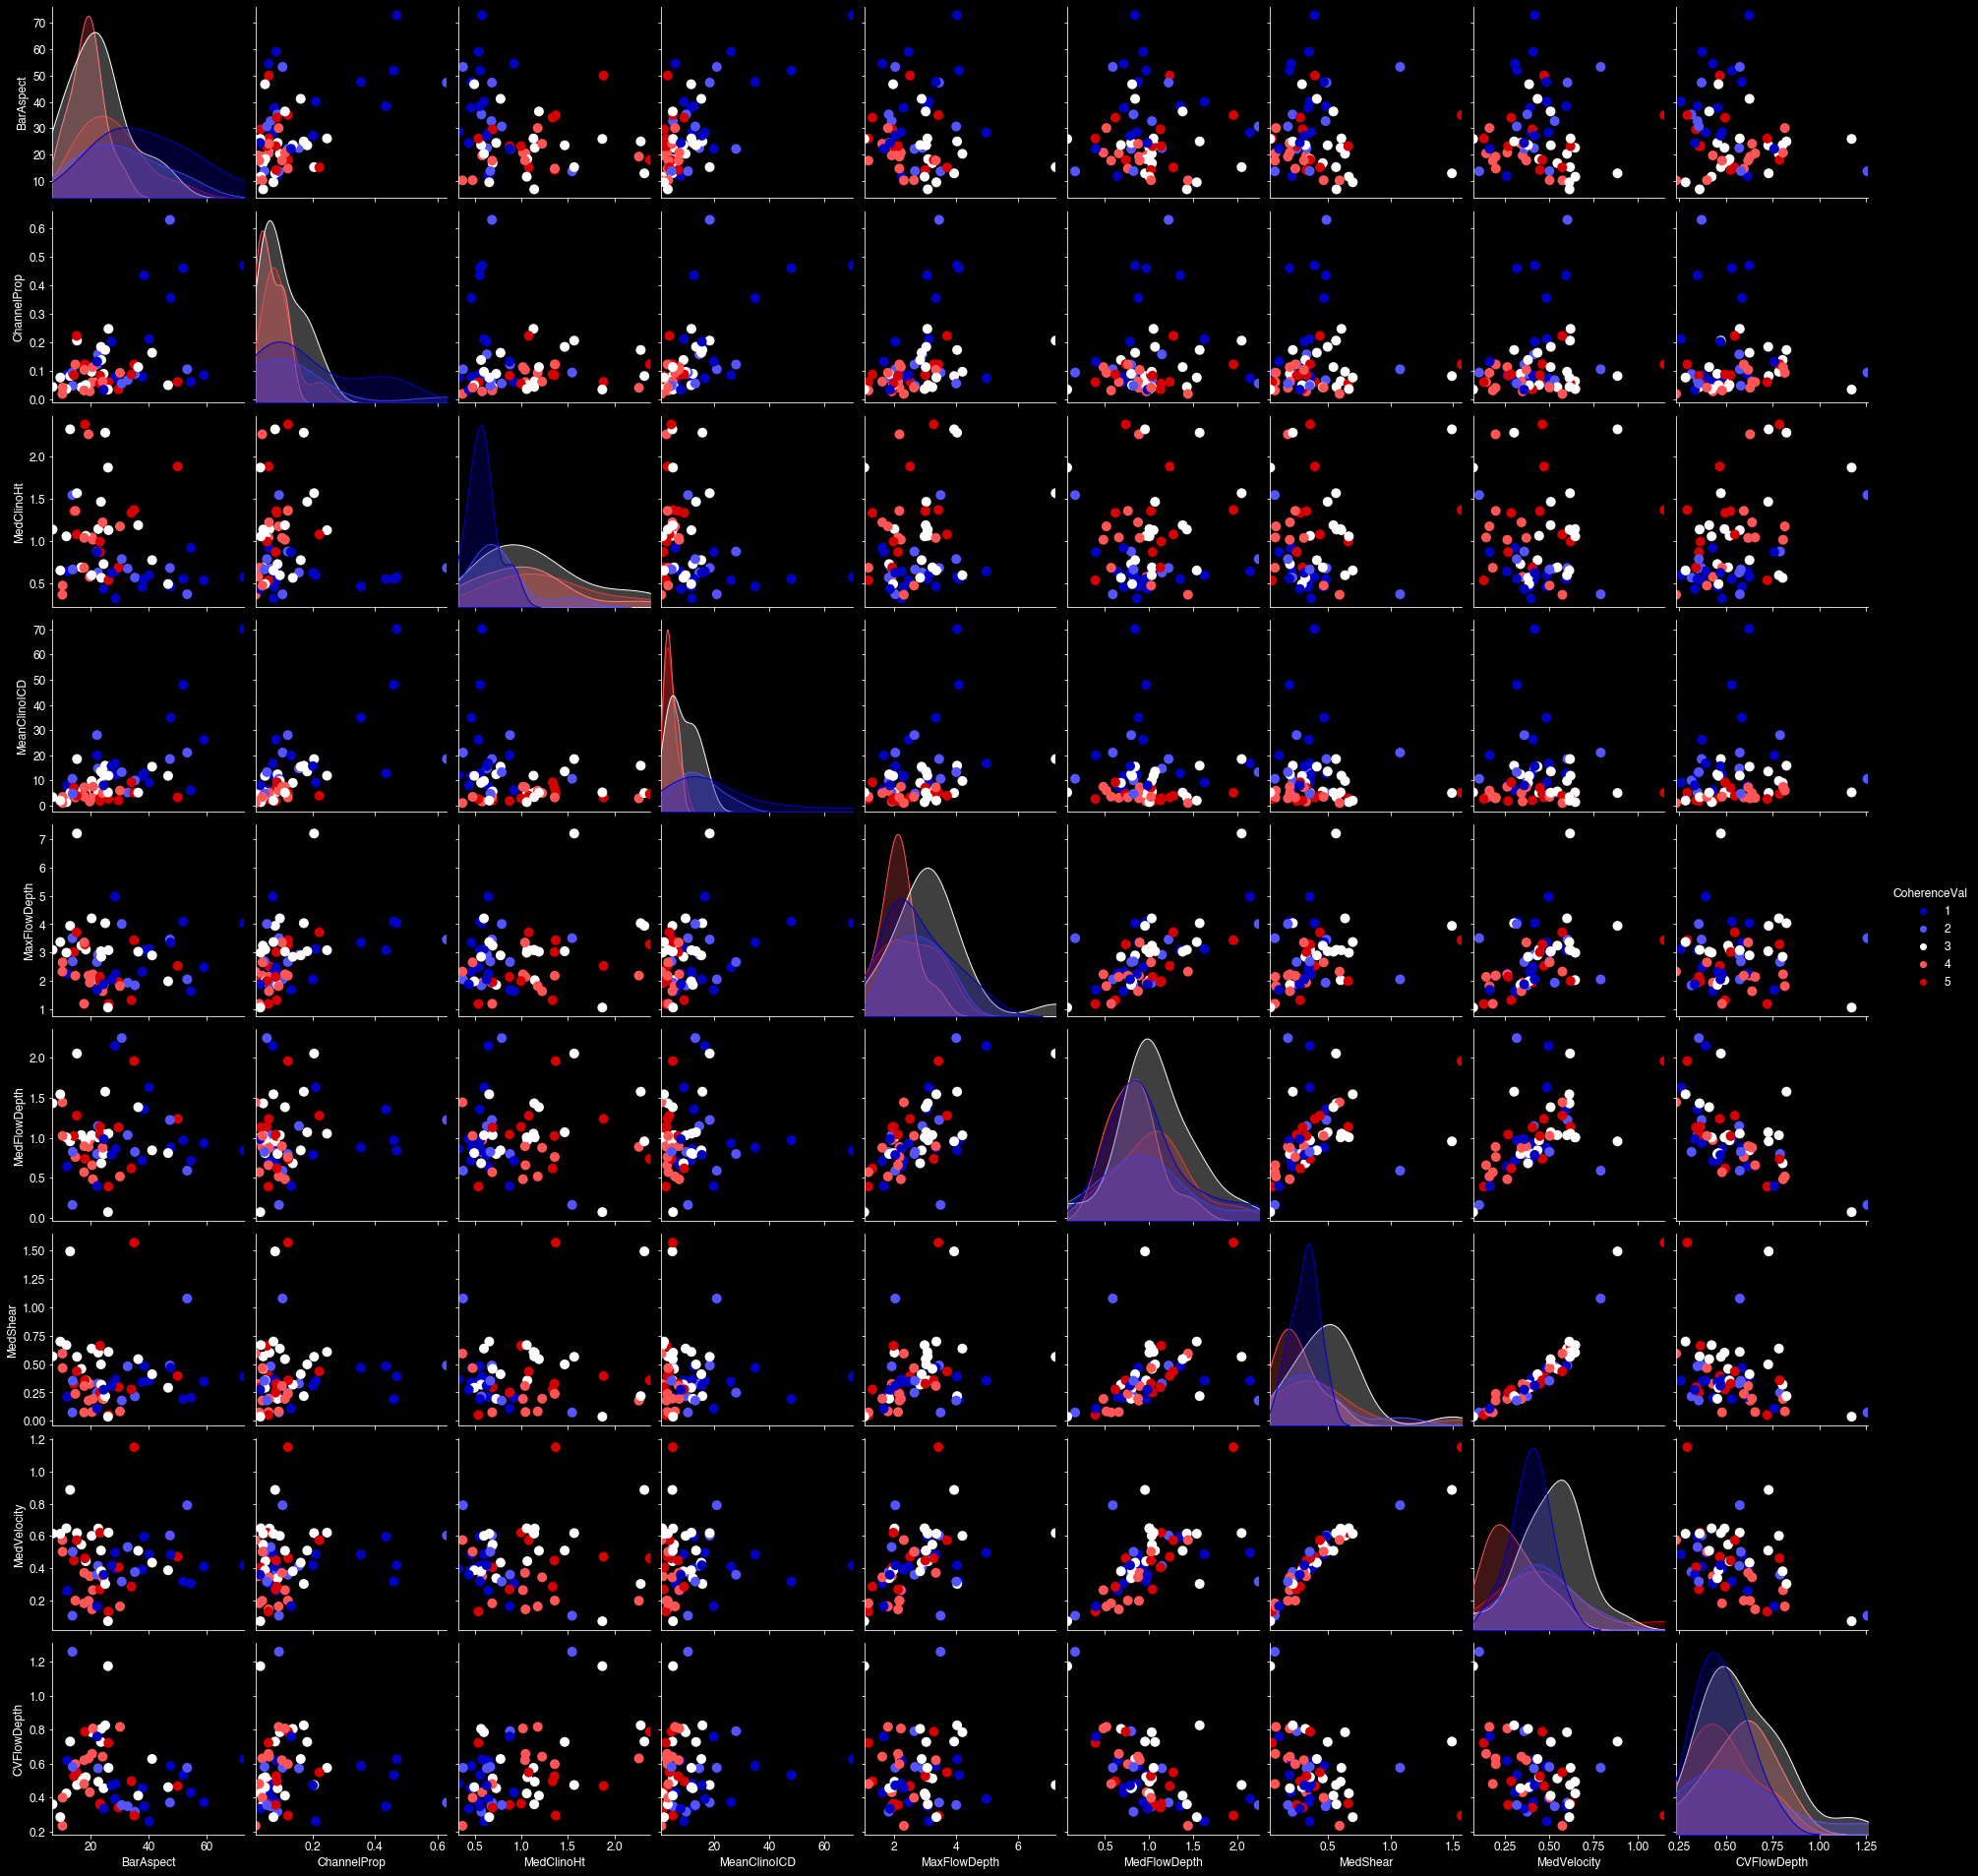

In [155]:
plt.figure(figsize = (20, 15))
with plt.style.context('dark_background'):
    pplot = sns.pairplot(allbars, 
                         plot_kws=dict(marker="o", linewidth=0, s = 100, edgecolor = 'w'),
                         vars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth'], hue = 'CoherenceVal', height = 3, aspect = 1, palette = sns.mpl_palette('seismic', 5))
    snsvars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth', 'Skew Abs', 'Basal Surf Relief']
    for i, v in enumerate(snsvars):
        pplot.axes[-1, i].set(xlim=(allbars[v].min(), allbars[v].max()))

    # pplot.set(xlim=(0, None))
    # pplot.axes[-1, 0].set(xlim=(0, 600))
    # plt.savefig(f'{savefilesto}/pairplot-test.png', dpi = 200)

In [32]:
sns.mpl_palette('seismic', 3)

[(0.00392156862745098, 0.00392156862745098, 1.0),
 (1.0, 0.9921568627450981, 0.9921568627450981),
 (0.9941176470588236, 0.0, 0.0)]

ValueError: The palette list has the wrong number of colors.

<Figure size 1080x1080 with 0 Axes>

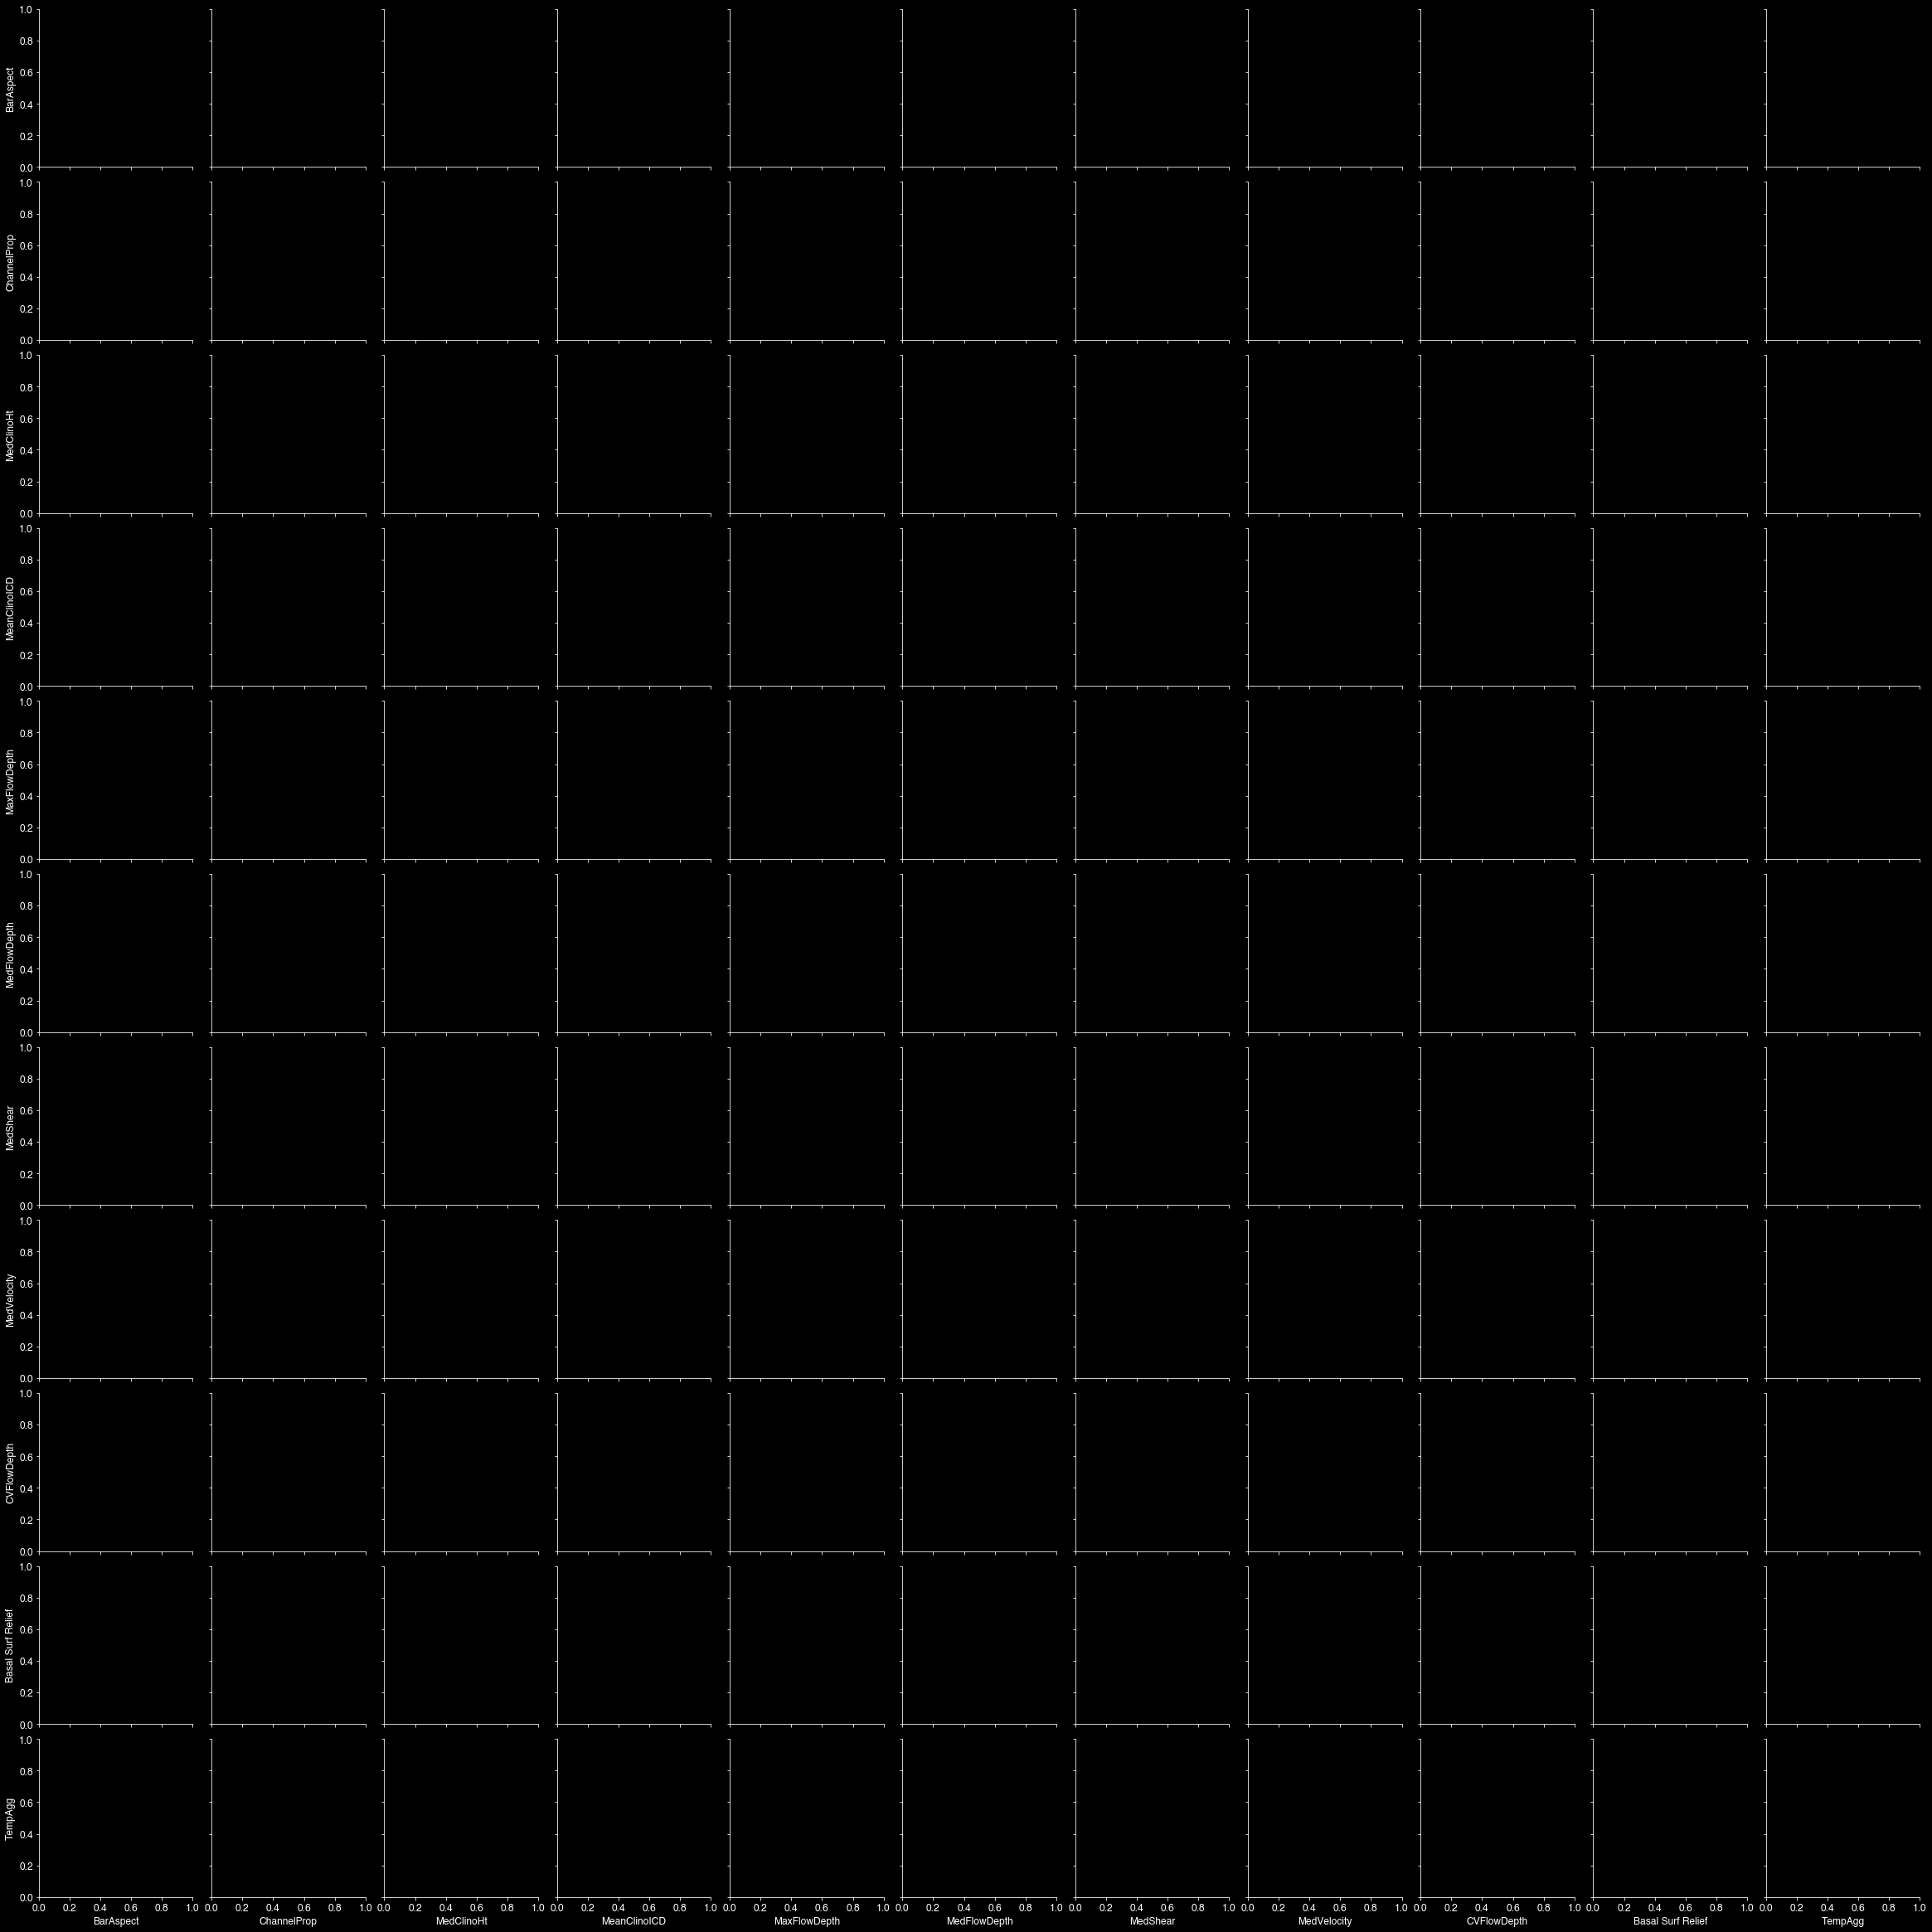

In [38]:
plt.figure(figsize = (15, 15))
with plt.style.context('dark_background'):
    pplot = sns.pairplot(allbars,
                         plot_kws=dict(marker="o", linewidth=0, s = 100, edgecolor = 'w'),
                         vars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth', 'Basal Surf Relief', 'TempAgg'], hue = 'Skew Binned', height = 3, aspect = 1, palette = sns.mpl_palette('seismic', 3))
    snsvars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth', 'Angle Skewness', 'TempAgg']
    for i, v in enumerate(snsvars):
        pplot.axes[-1, i].set(xlim=(0, allbars[v].max()))

# pplot.set(xlim=(0, None))
# pplot.axes[-1, 0].set(xlim=(0, 600))
plt.savefig(f'{savefilesto}/pairplot-cbskew.png', dpi = 200)

<Figure size 1080x1080 with 0 Axes>

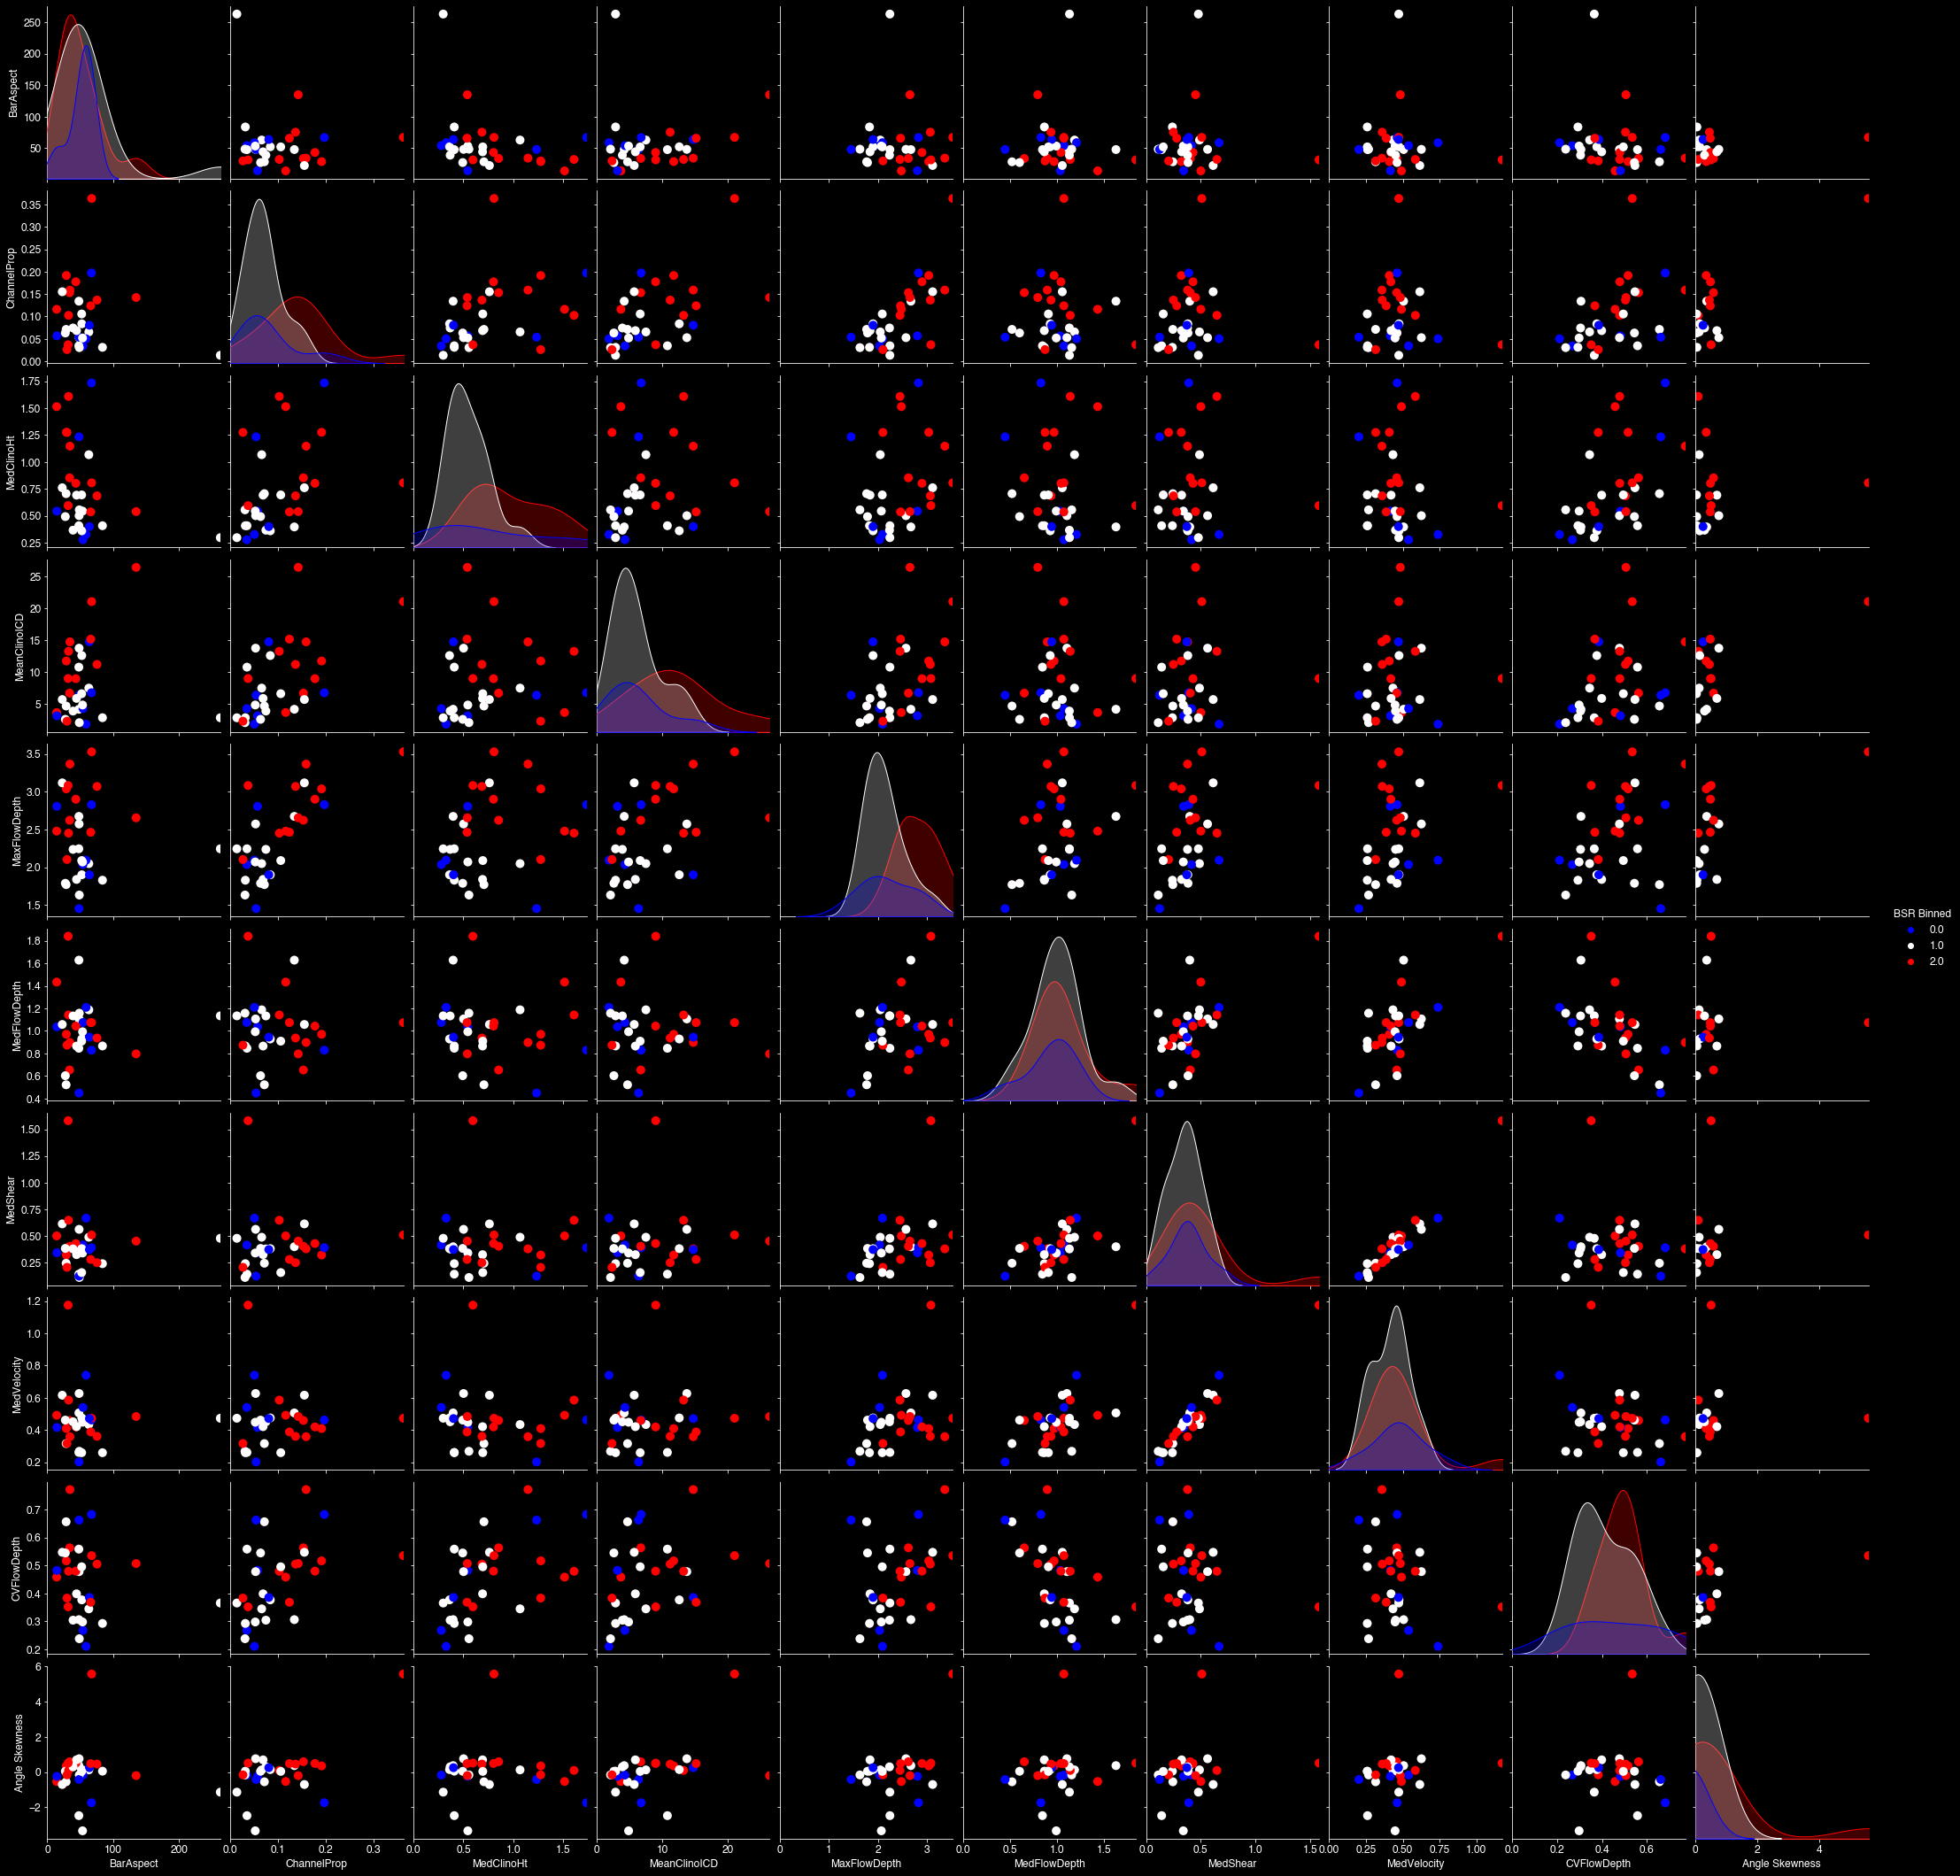

In [49]:
plt.figure(figsize = (15, 15))
with plt.style.context('dark_background'):
    pplot = sns.pairplot(allbars,
                         plot_kws=dict(marker="o", linewidth=0, s = 100, edgecolor = 'w'),
                         vars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth', 'Angle Skewness'], hue = 'BSR Binned', height = 3, aspect = 1, palette = sns.mpl_palette('seismic', 3))
    snsvars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth', 'Angle Skewness']
    for i, v in enumerate(snsvars):
        pplot.axes[-1, i].set(xlim=(0, allbars[v].max()))

# pplot.set(xlim=(0, None))
# pplot.axes[-1, 0].set(xlim=(0, 600))
plt.savefig(f'{savefilesto}/pairplot-cbbsr-bin.png', dpi = 200)

<Figure size 1080x1080 with 0 Axes>

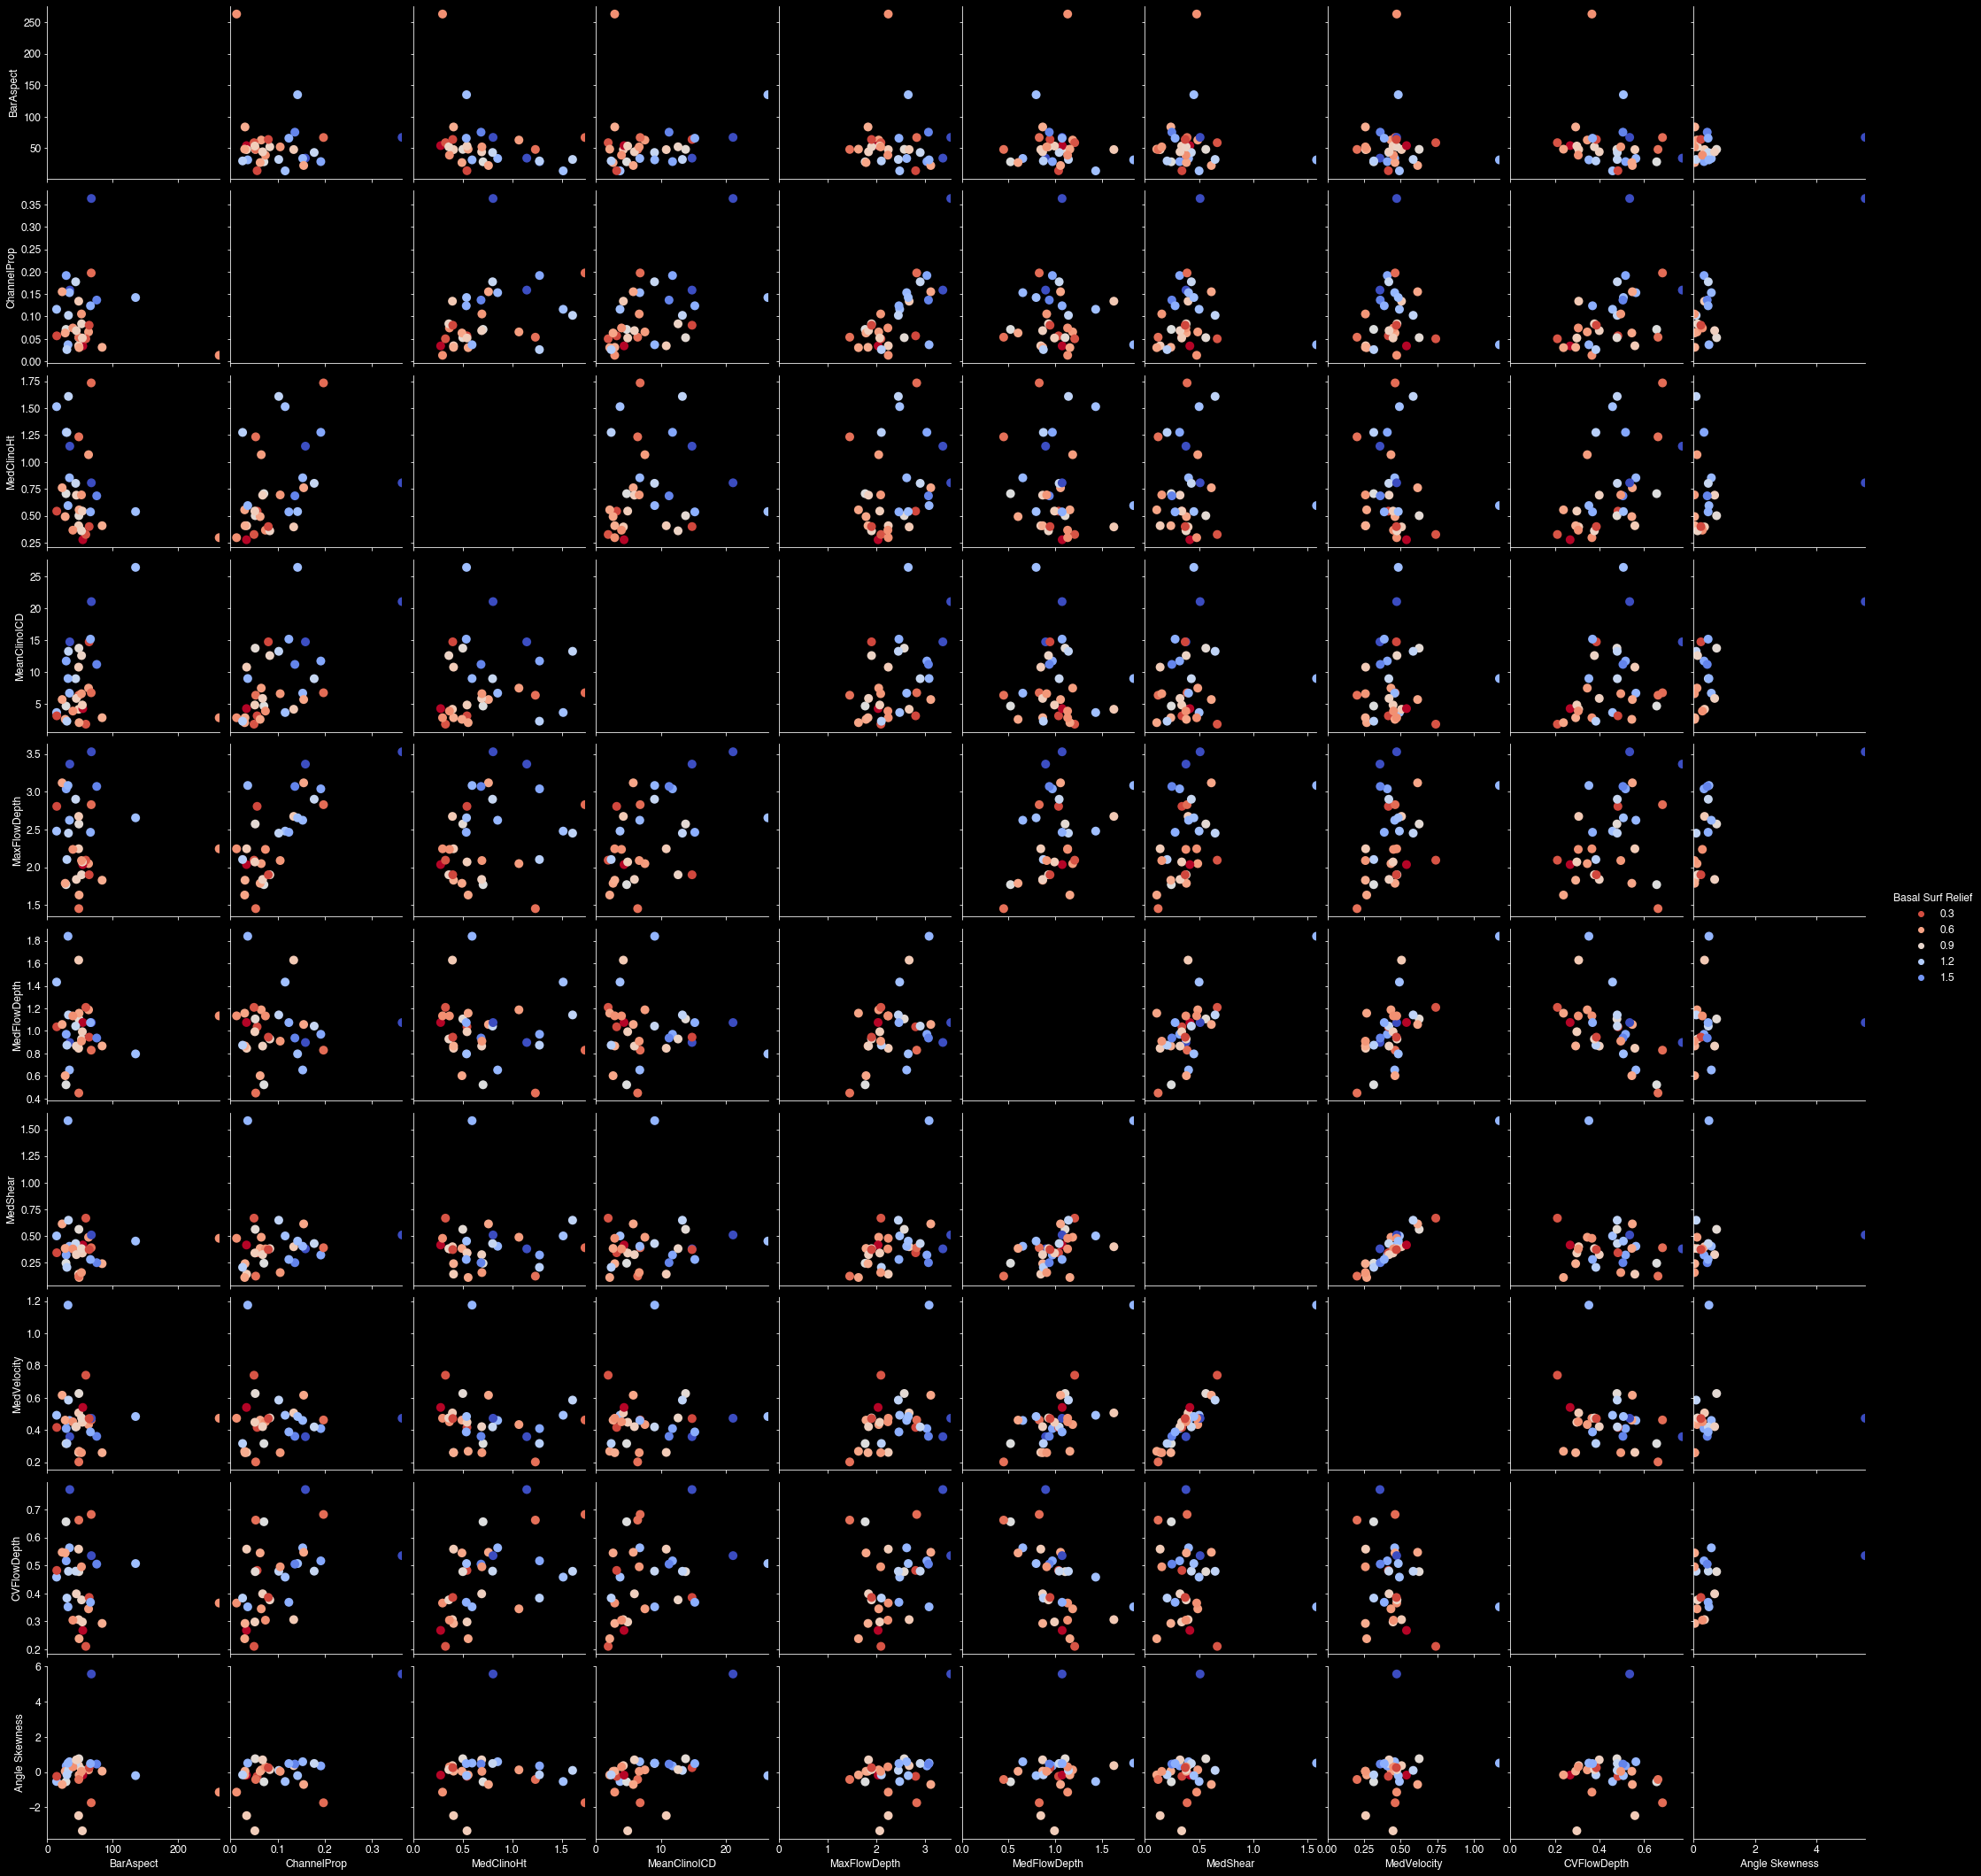

In [18]:
plt.figure(figsize = (15, 15))
with plt.style.context('dark_background'):
    pplot = sns.pairplot(allbars,
                         plot_kws=dict(marker="o", linewidth=0, s = 100),
                         vars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth', 'Angle Skewness'], hue = 'Basal Surf Relief', height = 3, aspect = 1, palette = 'coolwarm_r')
    snsvars = ['BarAspect', 'ChannelProp', 'MedClinoHt', 'MeanClinoICD', 'MaxFlowDepth', 'MedFlowDepth',
                                    'MedShear', 'MedVelocity', 'CVFlowDepth', 'Angle Skewness']
    for i, v in enumerate(snsvars):
        pplot.axes[-1, i].set(xlim=(0, allbars[v].max()))

# pplot.set(xlim=(0, None))
# pplot.axes[-1, 0].set(xlim=(0, 600))
plt.savefig(f'{savefilesto}/pairplot-cbbsr.png', dpi = 200)

In [28]:
pplot = sns.pairplot(allbars, vars = ['Angle Skewness', 'Basal Surf Relief'], hue =allbars['BarHeight'], palette = 'Spectral')
plot_kws={"s": 3}

snsvars = ['Angle Skewness', 'Basal Surf Relief']
for i, v in enumerate(snsvars):
    pplot.axes[-1, i].set(xlim=(allbars[v].min(), allbars[v].max()))
    
# pplot.set(xlim=(0, None))
# pplot.axes[-1, 0].set(xlim=(0, 600))
# plt.savefig(f'{savefilesto}/pairplot-cbskew.png', dpi = 200)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
sns.scatterplot(allbars['Angle Skewness'], allbars['Basal Surf Relief'], hue = allbars[''])

## Violin Plots

In [ ]:
Index(['BarName', 'array name', 'iloc', 'PreservChar', 'PresNum',
       'CoherenceVal', 'StartTime', 'EndTime', 'ElapsedTime', 'LeftEdge',
       'RightEdge', 'BarWidth', 'BarHeight', 'BarAspect', 'BarArea',
       'Section Area', 'ChannelProp', 'Angle Skewness', 'Basal Surf Relief',
       'Mean dzdx', 'Median dzdx', 'MinClinoHt', 'MaxClinoHt', 'ModeClinoHt',
       'MeanClinoHt', 'SDClinoHt', 'MedClinoHt', 'MinClinoWt', 'MaxClinoWt',
       'ModeClinoWt', 'MeanClinoWt', 'SDClinoWt', 'MedClinoWt', 'MinClinoICD',
       'MaxClinoICD', 'ModeClinoICD', 'MeanClinoICD', 'SDClinoICD',
       'MedClinoICD', 'MinFlowDepth', 'MaxFlowDepth', 'ModeFlowDepth',
       'MeanFlowDepth', 'SDFlowDepth', 'MedFlowDepth', 'MinShear', 'MaxShear',
       'ModeShear', 'MeanShear', 'SDShear', 'MedShear', 'MinVelocity',
       'MaxVelocity', 'ModeVelocity', 'MeanVelocity', 'SDVelocity',
       'MedVelocity', 'process interp', 'CVFlowDepth', 'CVVelocity',
       'Skew Abs', 'TempAgg', 'Skew Binned', 'Co Binned', 'BSR Binned',
       'MeanFacies', 'MedFacies'],
      dtype='object')

(array([423.,  14.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.10103618,  2.73310642,  5.36517666,  7.9972469 , 10.62931714,
        13.26138738, 15.89345762, 18.52552786, 21.1575981 , 23.78966834,
        26.42173858]),
 [<matplotlib.patches.Polygon at 0x7ff9ea5920a0>])

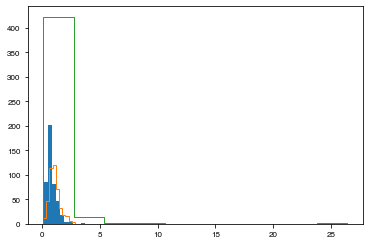

In [53]:
plt.hist(allbars['MedClinoHt'])
plt.hist(allbars['MedFlowDepth'], histtype = 'step')
plt.hist(allbars['MedClinoHt']/allbars['MedFlowDepth'], histtype = 'step')

(array([ 53., 199., 134.,  42.,   9.,   1.,   1.,   0.,   0.,   1.]),
 array([0.21326354, 0.55717399, 0.90108443, 1.24499487, 1.58890531,
        1.93281576, 2.2767262 , 2.62063664, 2.96454709, 3.30845753,
        3.65236797]),
 <BarContainer object of 10 artists>)

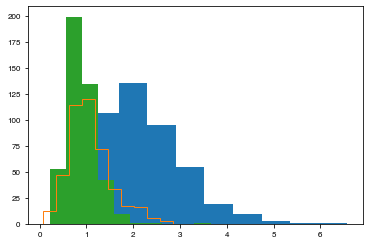

In [54]:
plt.hist(allbars['BarHeight'])
plt.hist(allbars['MedFlowDepth'], histtype = 'step')
plt.hist(allbars['BarHeight/MaxFD'])

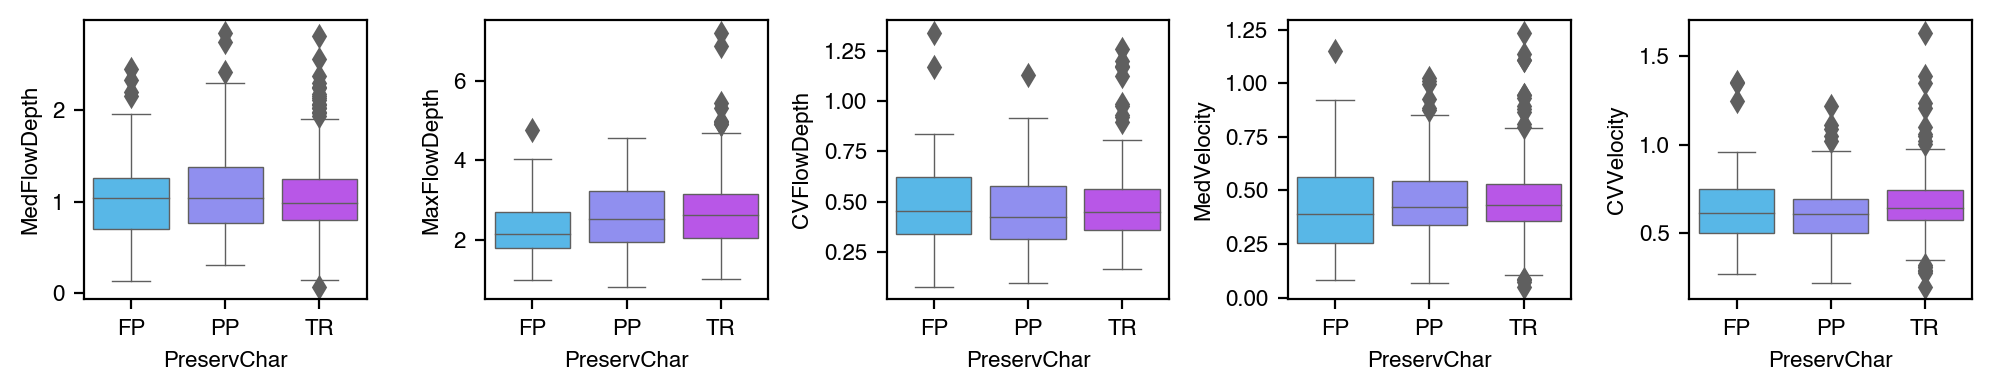

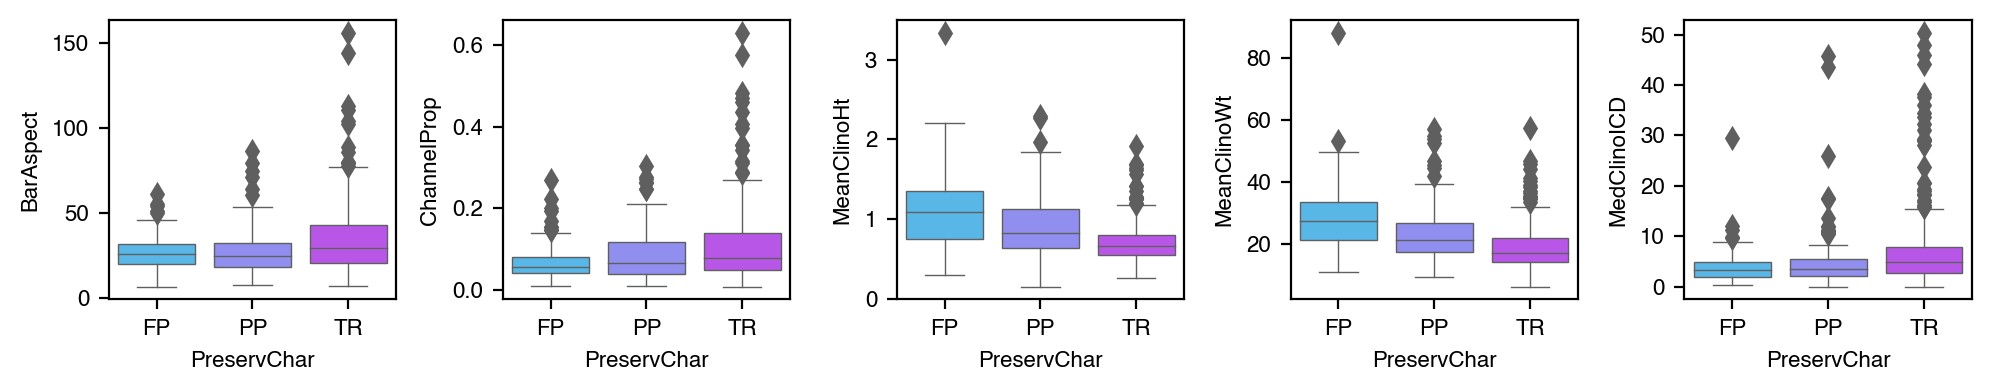

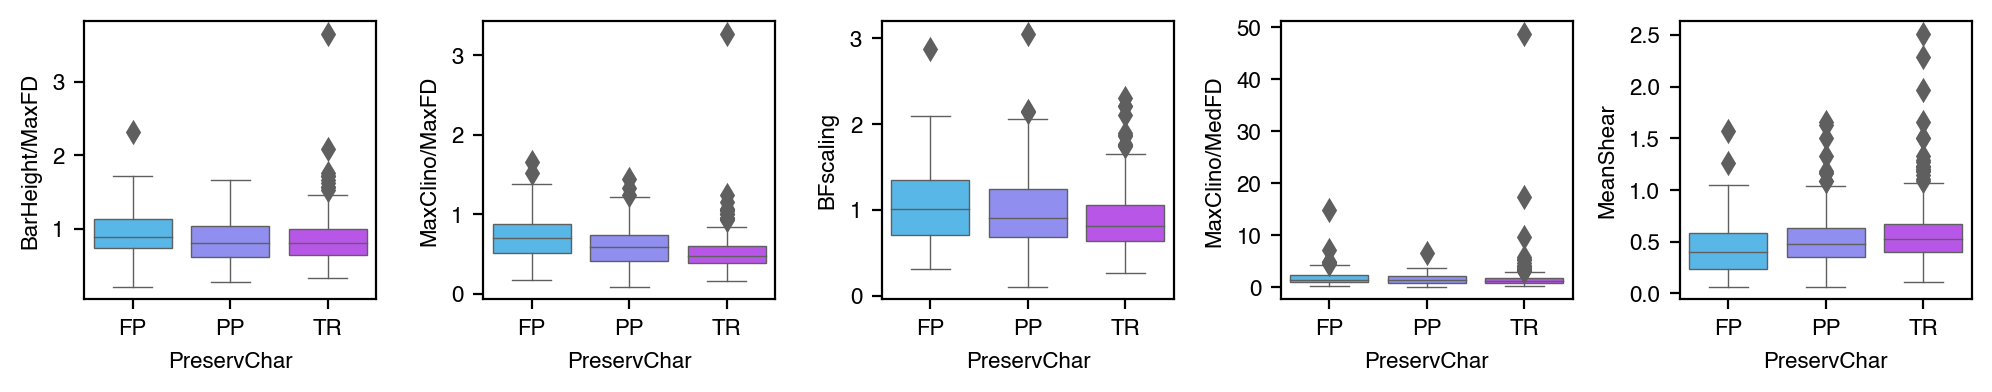

In [43]:
hydraulic_vars = ['MedFlowDepth', 'MaxFlowDepth','CVFlowDepth', 'MedVelocity', 'CVVelocity']
geometric_vars = ['BarAspect', 'ChannelProp', 'MeanClinoHt', 'MeanClinoWt', 'MedClinoICD']
scalers = ['BarHeight/MaxFD', 'MaxClino/MaxFD', 'BFscaling', 'MaxClino/MedFD', 'MeanShear']
fig, ax = plt.subplots(1, len(hydraulic_vars), figsize = (10, 2), dpi = 200, tight_layout = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    #sns.violinplot(data = allbars, x = 'PreservChar', y = hydraulic_vars[i], palette = sns.mpl_palette('cool', 3), ax = a, linewidth = 0.5, bw = 0.5)
    sns.boxplot(data = allbars, x = 'PreservChar', y = hydraulic_vars[i], palette = sns.mpl_palette('cool', 3), ax = a, linewidth = 0.5)#, bw = 0.5)
fig, ax = plt.subplots(1, len(geometric_vars), figsize = (10, 2), dpi = 200, tight_layout = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    # sns.violinplot(data = allbars, x = 'PreservChar', y = geometric_vars[i], palette = sns.mpl_palette('cool', 3), ax = a, linewidth = 0.5, bw = 0.5)
    sns.boxplot(data = allbars, x = 'PreservChar', y = geometric_vars[i], palette = sns.mpl_palette('cool', 3), ax = a, linewidth = 0.5)#, bw = 0.5)    
fig, ax = plt.subplots(1, len(scalers), figsize = (10, 2), dpi = 200, tight_layout = True)
# ax[3].set_ylim(0, 2)
# ax[2].set_ylim(0, 2)
ax = ax.ravel()
for i, a in enumerate(ax):
    # sns.violinplot(data = allbars, x = 'PreservChar', y = scalers[i], palette = sns.mpl_palette('cool', 3), ax = a, linewidth = 0.5, bw = 0.5)
    sns.boxplot(data = allbars, x = 'PreservChar', y = scalers[i], palette = sns.mpl_palette('cool', 3), ax = a, linewidth = 0.5)#, bw = 0.5)
# fig, ax = plt.subplots(1, len(scalers), figsize = (10, 3), dpi = 200, tight_layout = True)
# ax = ax.ravel()
# for i, a in enumerate(ax):
#     sns.violinplot(data = allbars, x = 'PreservChar', y = scalers[i], hue = 'BinFacMean', ax = a, split = True)
# plt.legend(loc = 'upper left')

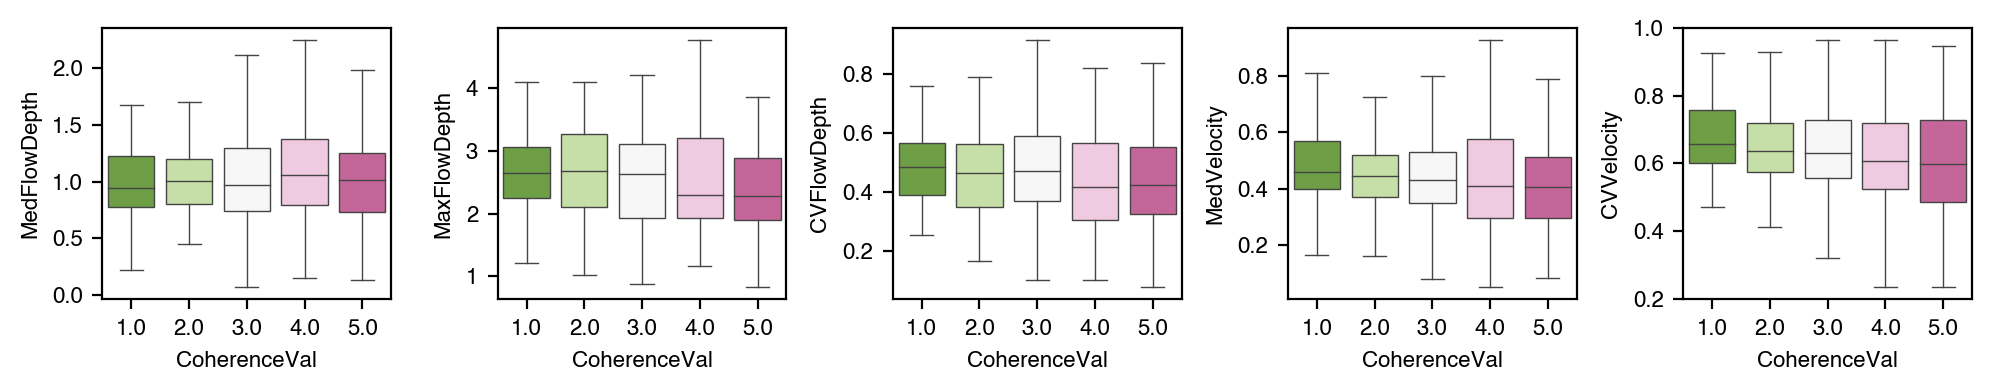

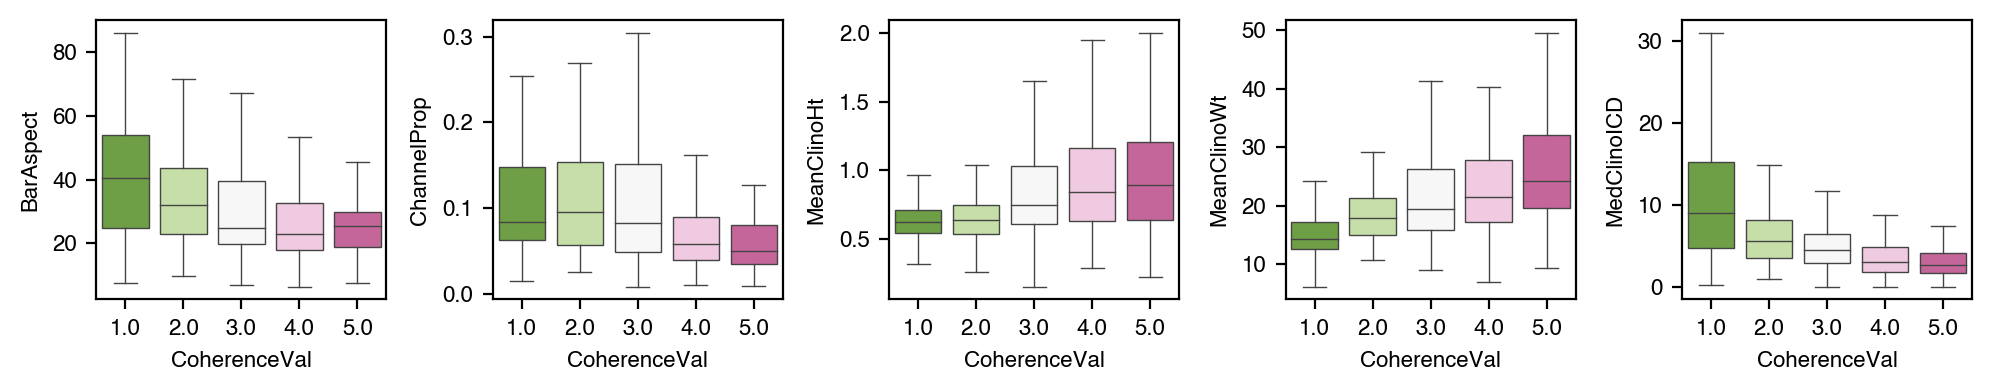

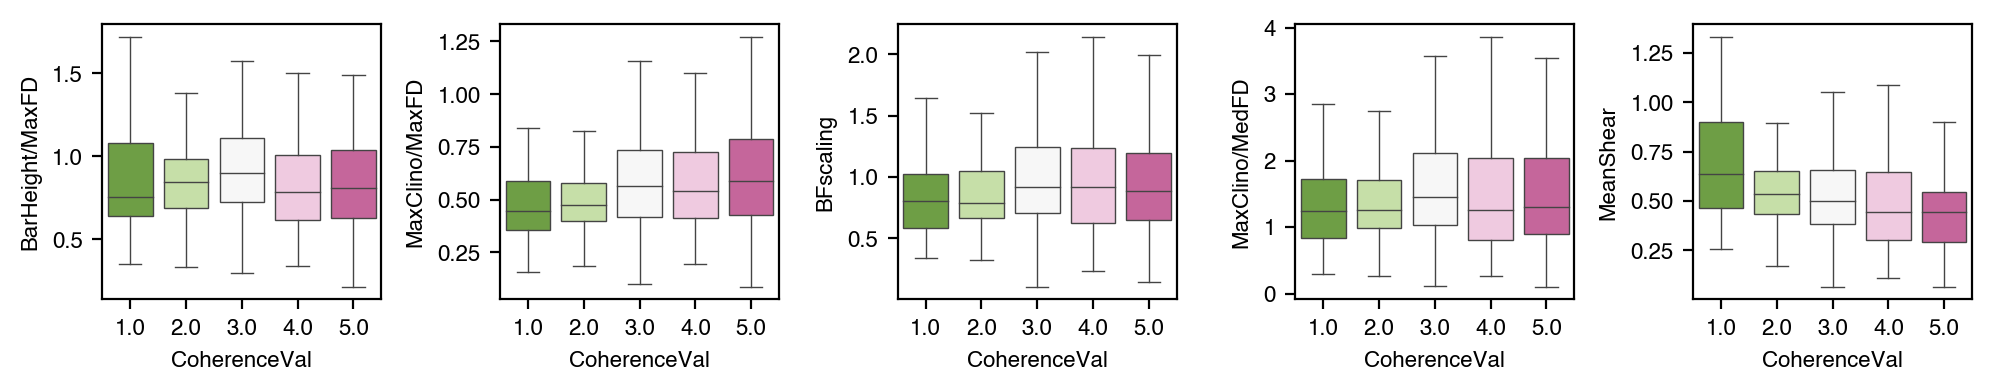

In [44]:
fig, ax = plt.subplots(1, len(hydraulic_vars), figsize = (10, 2), dpi = 200, tight_layout = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    sns.boxplot(data = allbars, x = 'CoherenceVal', y = hydraulic_vars[i], palette = sns.mpl_palette('PiYG_r', 5), ax = a, linewidth = 0.5, showfliers=False)#, bw = 0.5)
    
fig, ax = plt.subplots(1, len(geometric_vars), figsize = (10, 2), dpi = 200, tight_layout = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    sns.boxplot(data = allbars, x = 'CoherenceVal', y = geometric_vars[i], palette = sns.mpl_palette('PiYG_r', 5), ax = a, linewidth = 0.5, showfliers=False)#, bw = 0.5)
    
fig, ax = plt.subplots(1, len(scalers), figsize = (10, 2), dpi = 200, tight_layout = True)
# ax[3].set_ylim(0, 2)
# ax[2].set_ylim(0, 2)
ax = ax.ravel()
for i, a in enumerate(ax):
    sns.boxplot(data = allbars, x = 'CoherenceVal', y = scalers[i], palette = sns.mpl_palette('PiYG_r', 5), ax = a, linewidth = 0.5, showfliers=False)#, bw = 0.5)

# fig, ax = plt.subplots(1, len(scalers), figsize = (10, 3), dpi = 200, tight_layout = True)
# ax = ax.ravel()
# for i, a in enumerate(ax):
#     sns.violinplot(data = allbars, x = 'PreservChar', y = scalers[i], hue = 'BinFacMean', ax = a, split = True)


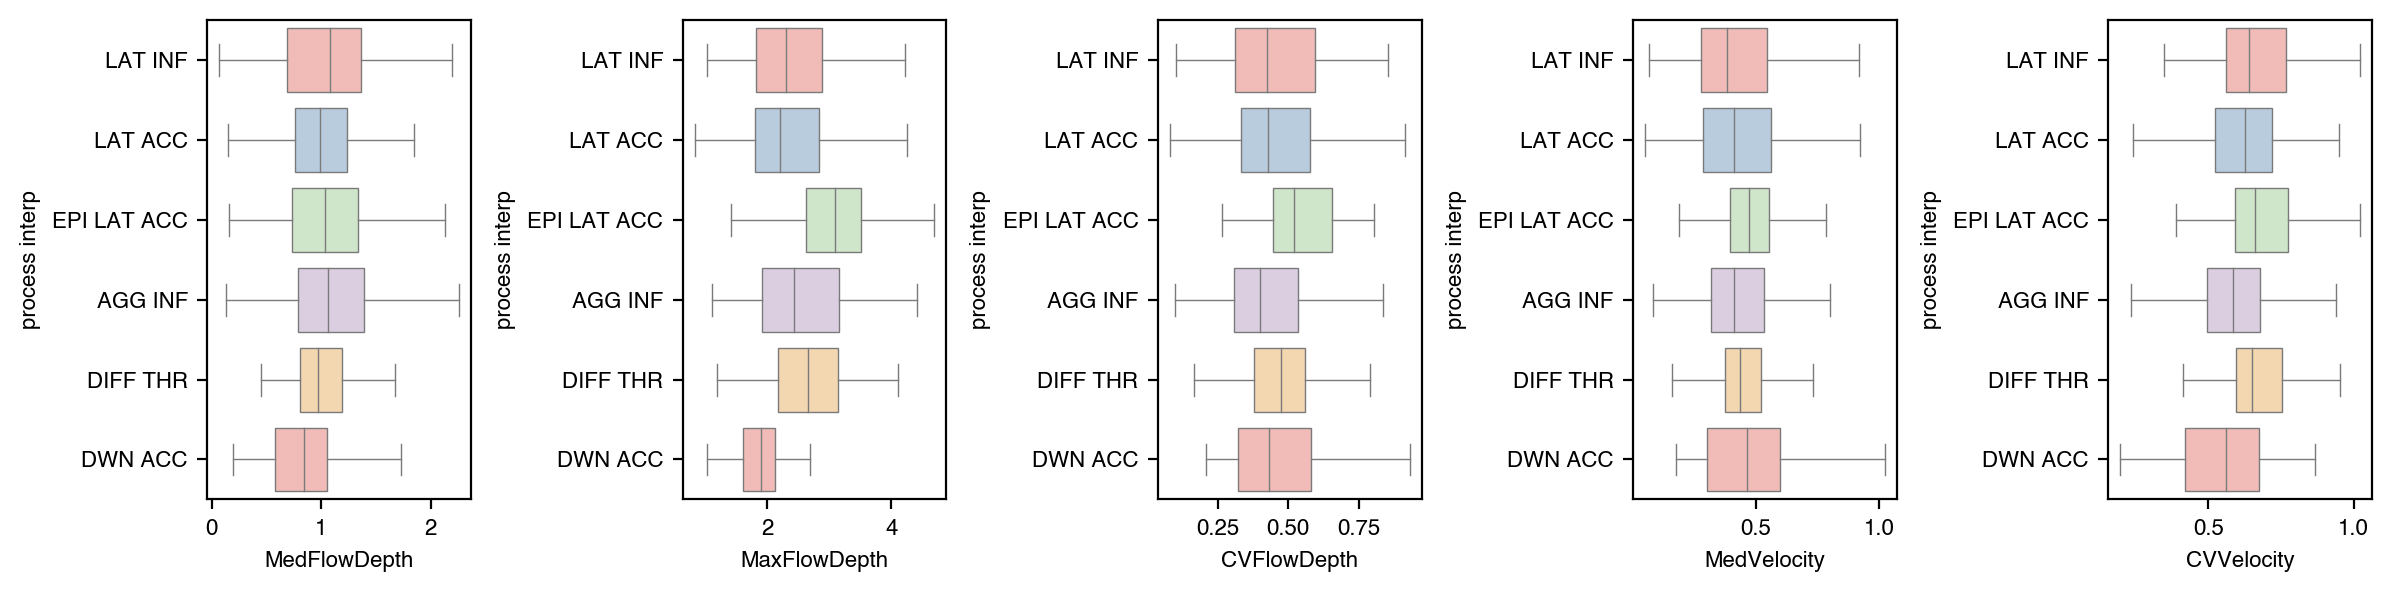

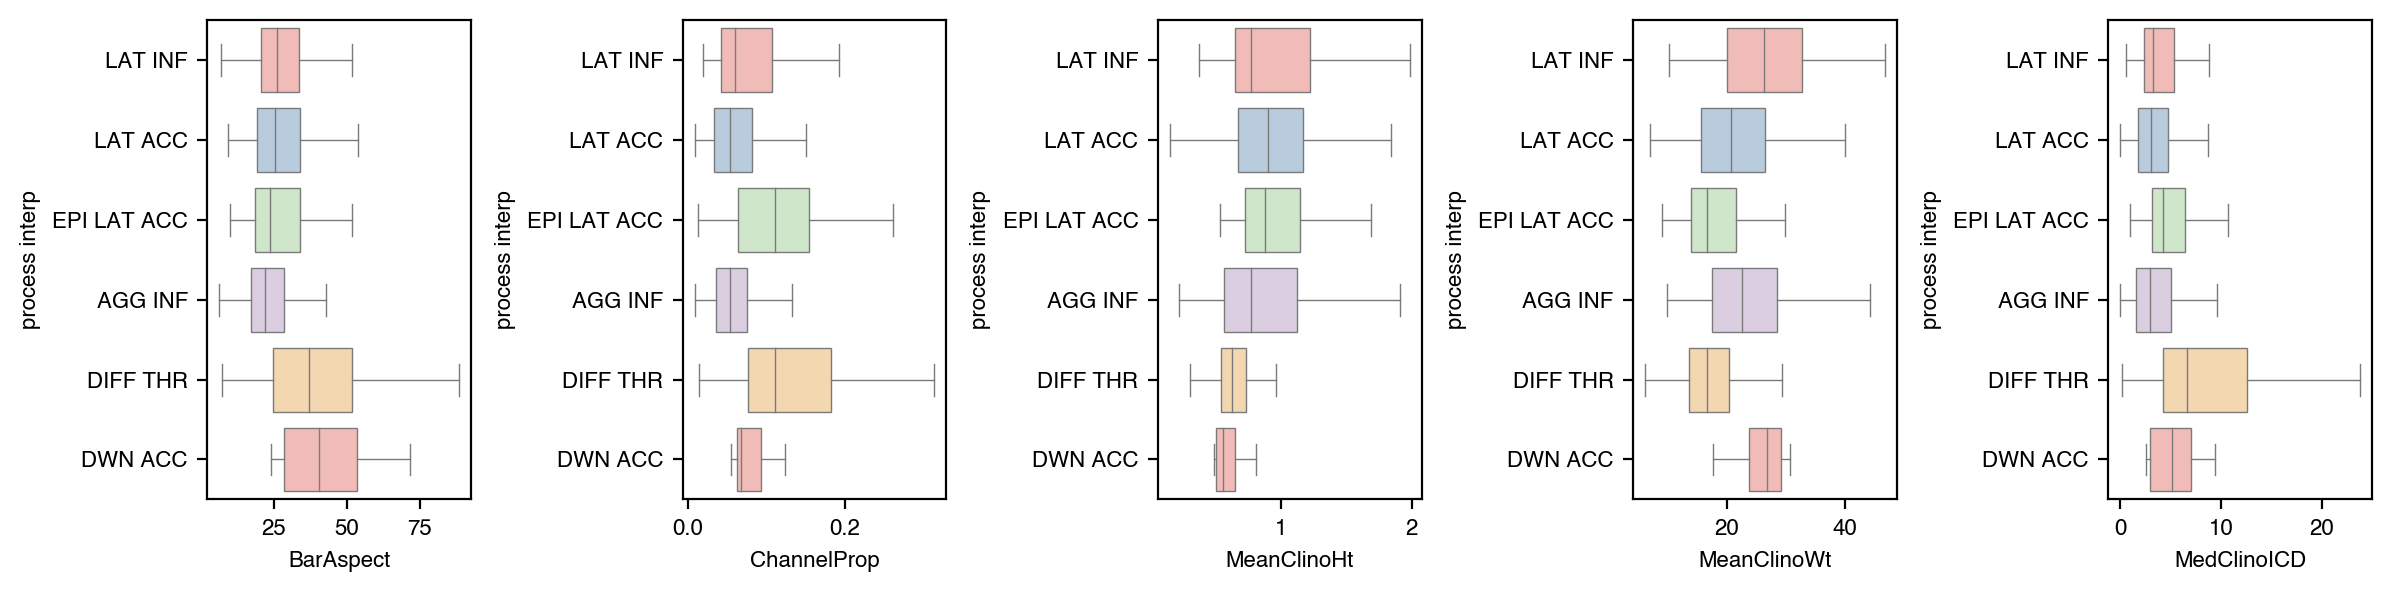

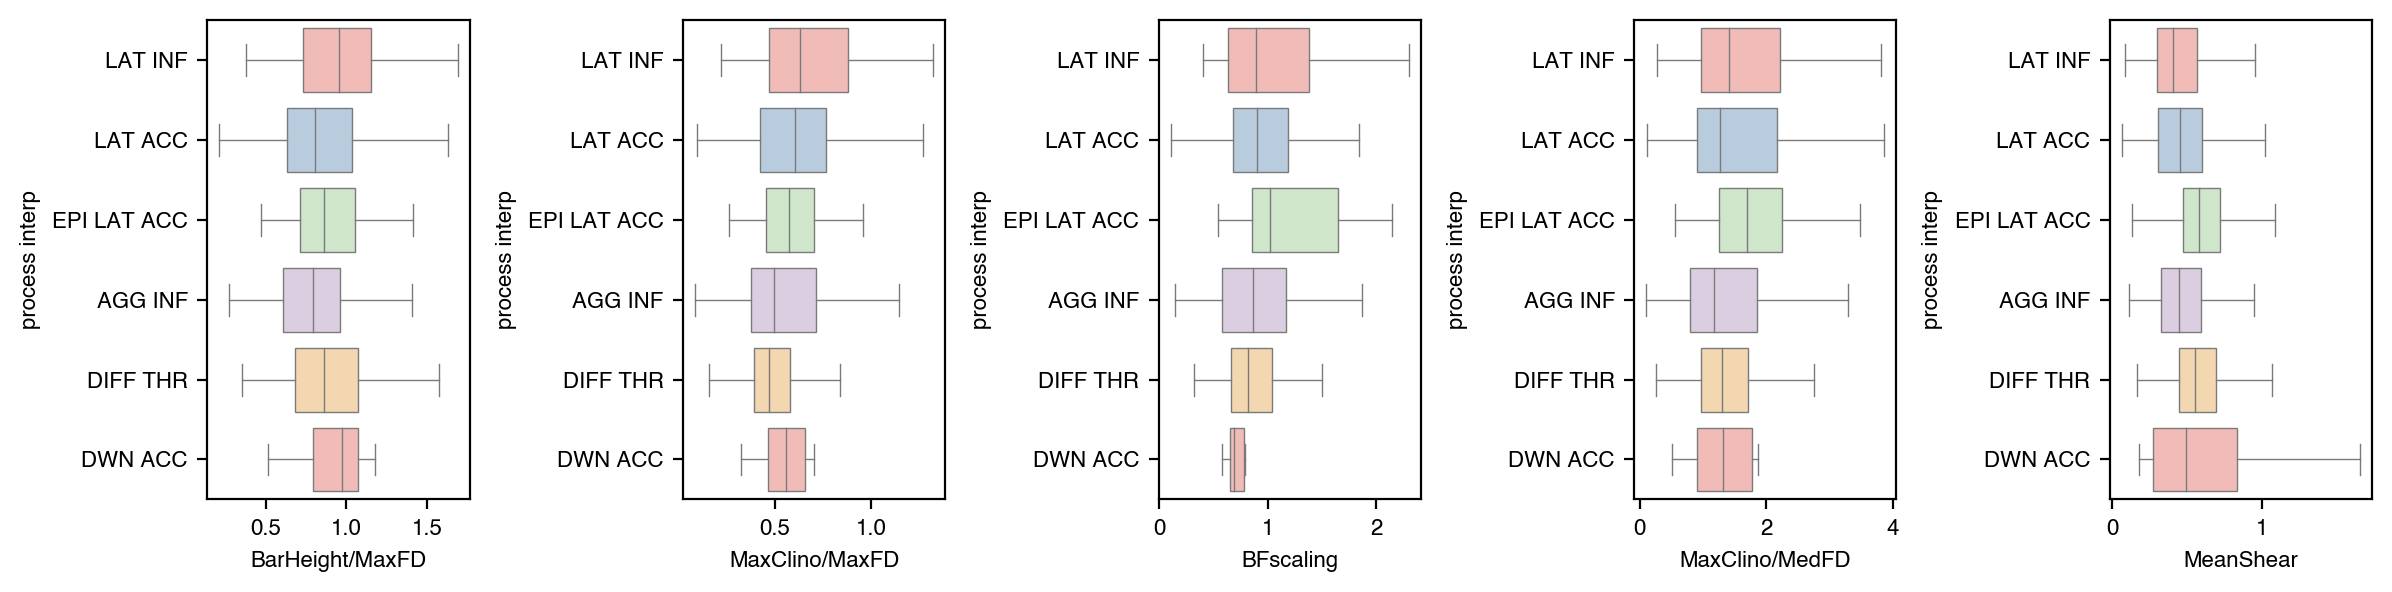

In [45]:

fig, ax = plt.subplots(1, len(hydraulic_vars), figsize = (12, 3), dpi = 200, tight_layout = True)
# plt.xticks(rotation=45)

ax = ax.ravel()
for i, a in enumerate(ax):
    # plt.xticks(rotation=45)
    # sns.violinplot(data = allbars, x = 'process interp', y = hydraulic_vars[i], palette = sns.mpl_palette('Pastel1', 5), ax = a, linewidth = 0.5, bw = 0.5)
    sns.boxplot(data = allbars, y = 'process interp', x = hydraulic_vars[i],  palette = sns.mpl_palette('Pastel1', 5), ax = a, linewidth = 0.5, showfliers=False, orient = "h")#, bw = 0.5)
    # plt.xticks(rotation=45)

    
fig, ax = plt.subplots(1, len(geometric_vars), figsize = (12, 3), dpi = 200, tight_layout = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    # sns.violinplot(data = allbars, x = 'process interp', y = geometric_vars[i], palette = sns.mpl_palette('Pastel1', 5), ax = a, linewidth = 0.5, bw = 0.5)
    sns.boxplot(data = allbars, y = 'process interp', x = geometric_vars[i],  palette = sns.mpl_palette('Pastel1', 5), ax = a, linewidth = 0.5, showfliers=False, orient = "h")#, bw = 0.5)
    
fig, ax = plt.subplots(1, len(scalers), figsize = (12, 3), dpi = 200, tight_layout = True)
ax[3].set_ylim(-1, 10)
ax[2].set_ylim(-1, 10)
ax = ax.ravel()
for i, a in enumerate(ax):
    # sns.violinplot(data = allbars, x = 'process interp', y = scalers[i], palette = sns.mpl_palette('Pastel1', 5), ax = a, linewidth = 0.5, bw = 0.5)
    sns.boxplot(data = allbars, y = 'process interp', x = scalers[i],  palette = sns.mpl_palette('Pastel1', 5), ax = a, linewidth = 0.5, showfliers=False, orient = "h")#, bw = 0.5)
    
# fig, ax = plt.subplots(1, len(scalers), figsize = (10, 3), dpi = 200, tight_layout = True)
# ax = ax.ravel()
# for i, a in enumerate(ax):
#     sns.violinplot(data = allbars, x = 'PreservChar', y = scalers[i], hue = 'BinFacMean', ax = a, split = True)


Find the percentage of upper and lower bar facies for each bar

In [20]:
bulkstats = pd.DataFrame(columns = ['Name', 'PropUB', 'PropLB'])
init = '/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/Summer-bpkg-redo/JULY142022'
for root, dirs, files in os.walk(init):
    for file in files:
        arr = np.load(os.path.join(root, file), allow_pickle = True)
        mmp = arr[:, :, -1] ## the arrays already have the mmp values in them
        tot = np.count_nonzero(~np.isnan(mmp))
#         vel = arr[:, :, 4] ##extract flow depth array
#         dep = arr[:, :, 3] ##extract flow depth array
#         depnan = copy.deepcopy(dep)
#         depnan[dep<0] = np.nan
#         # depnan[dep<0] = 0.0000001
#         tot = (arr.shape[0]*arr.shape[1])-np.count_nonzero(np.isnan(depnan)) ## because we have to find the not nan proportion?
        
#         numnans = np.count_nonzero(np.isnan(dep))
#         if numnans > 0:
#             plt.hist(dep.ravel(), histtype = 'step')
#         # print(file, tot, np.count_nonzero(np.isnan(dep)))

#         mmp =(1000*(vel**2))/(1650*((18*(np.log10(4*depnan/d50)))**2)*d50)##### modified mobility parameter
        
        pub = (mmp < 0.17).sum()/tot
        plb = (mmp > 0.17).sum()/tot
        dats = pd.DataFrame(np.array([file, pub, plb]).reshape(1, 3), columns = ['Name', 'PropUB', 'PropLB'])
        bulkstats = pd.concat([bulkstats, dats], ignore_index = True)
        # cv_flowdepth = stats.variation(arr, axis = 1)

In [21]:
bulkstats['PreservChar'] = copy.deepcopy(bulkstats['Name'])
bulkstats['CoherenceVal'] = copy.deepcopy(bulkstats['Name'])
for i in range(0, len(bulkstats)):
    bulkstats['PreservChar'].iloc[i] = bulkstats['Name'].iloc[i][4:6]
    bulkstats['CoherenceVal'].iloc[i] = bulkstats['Name'].iloc[i][7:8]

In [22]:
bulkstats = bulkstats.explode('PropUB')
bulkstats['PropUB'] = bulkstats['PropUB'].astype('float')
bulkstats = bulkstats.explode('PropLB')
bulkstats['PropLB'] = bulkstats['PropLB'].astype('float')


<AxesSubplot:xlabel='CoherenceVal', ylabel='PropUB'>

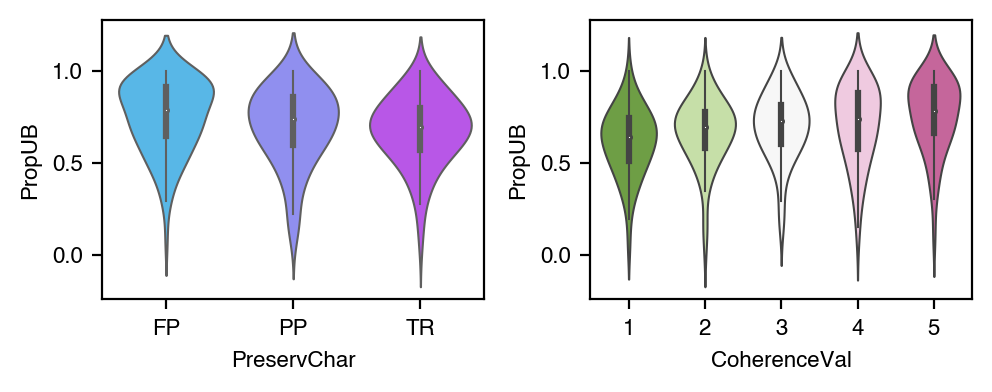

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (5, 2), dpi = 200, tight_layout=True)
sns.violinplot(data = bulkstats, x = 'PreservChar', y = 'PropUB', palette = sns.mpl_palette('cool', 3), linewidth = 0.75, bw = .5, ax = ax[0]);
sns.violinplot(data = bulkstats.sort_values(by=['CoherenceVal'], ascending = True), x = 'CoherenceVal', y = 'PropUB', palette = sns.mpl_palette('PiYG_r', 5), linewidth = 0.75, bw = 0.5, alpha = 0.4, ax = ax[1])
# sns.violinplot(data = bulkstats, x = 'PreservChar', y = 'PropLB', palette = sns.mpl_palette('cool', 3), linewidth = 0.75, bw = 0.1, saturation = 0.3);

<AxesSubplot:xlabel='CoherenceVal', ylabel='PropUB'>

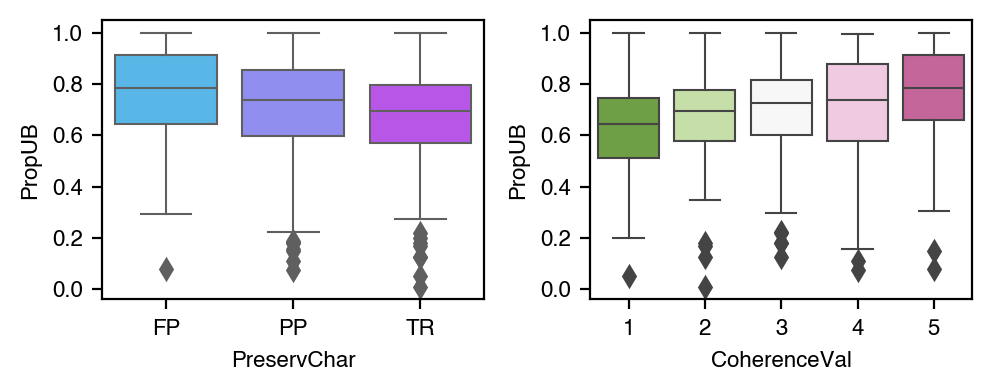

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (5, 2), dpi = 200, tight_layout=True)
sns.boxplot(data = bulkstats, x = 'PreservChar', y = 'PropUB', palette = sns.mpl_palette('cool', 3), linewidth = 0.75, ax = ax[0]);
sns.boxplot(data = bulkstats.sort_values(by=['CoherenceVal'], ascending = True), x = 'CoherenceVal', y = 'PropUB', palette = sns.mpl_palette('PiYG_r', 5), linewidth = 0.75, ax = ax[1])
# sns.violinplot(data = bulkstats, x = 'PreservChar', y = 'PropLB', palette = sns.mpl_palette('cool', 3), linewidth = 0.75, bw = 0.1, saturation = 0.3);

In [ ]:
sns.histplot(data = allbars, )